In [317]:
## Import necessary packages
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None
import pickle
import numpy as np
from datetime import date, datetime, timedelta
import os
os.chdir("C:\\Summer_2017\\Job")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# Part I   Data analysis:

# Question 1 
## Which station has the most number of units as of today?

## Process:
* First download the most recent week's dataset, which is on 06/24/2017.
* Slice the data, only keep the data of the current date.
* Apply the groupby function to count the Unit of each station 

## a) Download and Slice the Data

In [211]:
mostRecent = pd.read_table("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt", sep=',')

In [212]:
# query dataframe that contains only today's data
today = mostRecent[mostRecent.DATE == '06/23/2017']

In [213]:
today.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
36,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2017,00:00:00,REGULAR,6232184,2109920
37,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2017,04:00:00,REGULAR,6232214,2109925
38,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2017,08:00:00,REGULAR,6232261,2110012
39,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2017,12:00:00,REGULAR,6232419,2110275
40,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2017,16:00:00,REGULAR,6232792,2110350


## b) Understand the Structure of Data

* See following chart to get a better understanding of the hierachical relation between:**'STATION','UNIT','C/A','SCP'**

In [214]:
# Show the Structure
key = ['STATION','UNIT','C/A','SCP']
mostRecent.groupby(key).count().head(10)

LINENAME  DIVISION  DATE  TIME  DESC  ENTRIES  \
STATION UNIT C/A  SCP                                                       
1 AV    R248 H007 00-00-00        43        43    43    43    43       43   
                  00-00-01        43        43    43    43    43       43   
                  00-03-00        43        43    43    43    43       43   
                  00-03-01        42        42    42    42    42       42   
                  00-03-02        43        43    43    43    43       43   
             H008 01-00-00        42        42    42    42    42       42   
                  01-00-01        42        42    42    42    42       42   
                  01-00-02        42        42    42    42    42       42   
                  01-00-03        42        42    42    42    42       42   
                  01-00-04        42        42    42    42    42       42   

                            EXITS                                                                 
STATION UNIT C/A  SCP                                                                             
1 AV    R248 H007 00-00-00                                                 43                     
                  00-00-01                                                 43                     
                  00-03-00                                                 43                     
                  00-03-01                                                 42                     
                  00-03-02                                                 43                     
             H008 01-00-00                                                 42                     
                  01-00-01                                                 42                     
                  01-00-02                                                 42                     
                  01-00-03                                                 42                     
                  01-00-04                                                 42

## c) Use GroupBy function to count UNIT at each STATION

In [215]:
# Group the data on STATION and UNIT together
CountOnStationUnit = today.groupby(["STATION","UNIT"]).count().reset_index()
CountOnStationUnit.head()

,STATION,UNIT,C/A,SCP,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,1 AV,R248,60,60,60,60,60,60,60,60,60
1,103 ST,R180,36,36,36,36,36,36,36,36,36
2,103 ST,R191,36,36,36,36,36,36,36,36,36
3,103 ST,R314,18,18,18,18,18,18,18,18,18
4,103 ST-CORONA,R208,54,54,54,54,54,54,54,54,54


In [216]:
# Group the data on STATION again to count the the number of UNIT at each STATION
result = CountOnStationUnit.groupby(["STATION"])["UNIT"].size().reset_index(name="Number of Units")
result.head(5)

,STATION,Number of Units
0,1 AV,1
1,103 ST,3
2,103 ST-CORONA,1
3,104 ST,2
4,110 ST,1


In [217]:
# Find the STATION with most number of UNIT
result.sort_values('Number of Units', ascending = False).head(1)

,STATION,Number of Units
46,23 ST,6


#### So, 23 ST Station has the most number of units as of today, with 6 Units.

# Question 2 
## What is the total number of entries & exits across the subway system for August 1, 2013?

## Process:

1. Download the week's data that contains the date: Aug 1st, 2013

2. Transform the data into format of data after Oct 18th 2014 (one ENTRIES & EXITS each row)

3. Copy the data at 00:00:00 Aug 2,2013, modify the time to 23:59:00 Aug 1, 2013, concatenate it to the original dataframe, since the counts are equivalent to an “odometer” reading for each device. The counts at 00:00:00 Aug 2, 2013 is the actual last count for Aug 1, 2013.

4. Data Validation: 
    1. Go across some data issues for all data in 2013 and figure out how to solve them.
    2. Validate the weekly data containing Aug 1, 2013.
    
5. Map the data with STATION on UNIT and C/A, based on the current data that is most closed to Oct 18th 2014

6. Group the data on 'STATION','UNIT','C/A','SCP', and do related calculations

## a) Download the data of week Aug 3rd, 2013

In [225]:
Aug1 = pd.read_table("http://web.mta.info/developers/data/nyct/turnstile/turnstile_130803.txt", sep=',',header=-1, \
                     names = ['C/A','UNIT','SCP','DATE1','TIME1','DESC1','ENTRIES1','EXITS1','DATE2','TIME2','DESC2',\
                              'ENTRIES2','EXITS2','DATE3','TIME3','DESC3','ENTRIES3','EXITS3','DATE4','TIME4','DESC4',\
                              'ENTRIES4','EXITS4','DATE5','TIME5','DESC5','ENTRIES5','EXITS5','DATE6','TIME6','DESC6',\
                              'ENTRIES6','EXITS6','DATE7','TIME7','DESC7','ENTRIES7','EXITS7','DATE8','TIME8','DESC8','ENTRIES8','EXITS8'])

In [226]:
Aug1.head(1)

,C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8
0,A002,R051,02-00-00,07-27-13,00:00:00,REGULAR,4209603,1443585,07-27-13,04:00:00,REGULAR,4209643.0,1443593.0,07-27-13,08:00:00,REGULAR,4209663.0,1443616.0,07-27-13,12:00:00,REGULAR,4209741.0,1443687.0,07-27-13,16:00:00,REGULAR,4210004.0,1443740.0,07-27-13,20:00:00,REGULAR,4210276.0,1443777.0,07-28-13,00:00:00,REGULAR,4210432.0,1443801.0,07-28-13,04:00:00,REGULAR,4210472.0,1443805.0


## b) Transform the data to Current Format
> The Raw data have 8 records of ENTRIES & EXITS each row,  we will split them and transform each row in raw data to 8 rows, each new row have only one record for ENTRIES & EXITS.

In [229]:
# Transform the data, split it and resemble
def transform(data):
    """
    :type data: Pandas DataFrame
    :rtype: Pandas DataFrame
    """
    result = []
    for i in range(1,9):
        tempDF = data[['C/A','UNIT','SCP','DATE'+str(i),'TIME'+str(i),'DESC'+str(i),'ENTRIES'+str(i),'EXITS'+str(i)]]
        tempDF.columns = [['C/A','UNIT','SCP','DATE','TIME','DESC','ENTRIES','EXITS']]
        
        # first loop
        if len(result) < 1:
            result = tempDF 
        # after first loop
        else:
            result = pd.concat([result,tempDF])
    return result

In [230]:
# Transform the week data that contain Aug 1, 2013
transformed = transform(Aug1)
transformed.head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,07-27-13,00:00:00,REGULAR,4209603.0,1443585.0
1,A002,R051,02-00-00,07-28-13,08:00:00,REGULAR,4210490.0,1443821.0
2,A002,R051,02-00-00,07-29-13,16:00:00,REGULAR,4211586.0,1444302.0
3,A002,R051,02-00-00,07-30-13,14:01:46,LOGON,4213192.0,1444700.0
4,A002,R051,02-00-00,07-30-13,16:00:00,REGULAR,4213333.0,1444737.0


## c) Copy the data at 00:00:00 Aug 2,2013, modify the time to 23:59:00 Aug 1, 2013
> Since the record is like a odometer, we need to read the counts at 00:00:00 today and at 00:00:00 on the next day, to record the total number of ENTRIES & EXITS of today.

> When we query the data of today, we will omit the data at 00:00:00 on the next day, to fix this problem, we make a copy of all the data at 00:00:00, and change the time to 23:59:00 of the previous day.

In [231]:
# Copy and paste count at current day 00:00:00 -> previous day 23:59:00
def addtheLastCount(data, today, nextday):
    """
    :type data: Pandas DataFrame
    :type today: String of Date,'mm-dd-yy'
    :type today: String of Date,'mm-dd-yy'
    :rtype: Pandas DataFrame
    """
    tmp = data[(data.DATE == nextday) & (data.TIME == '00:00:00')]
    tmp.loc[:,'DATE'] = today
    tmp.loc[:,'TIME'] = '23:59:00'
    return pd.concat([data,tmp])

In [232]:
today = '08-01-13'
nextday = '08-02-13'
Expanded = addtheLastCount(transformed,today,nextday)

In [233]:
Expanded[Expanded.TIME == '23:59:00'].head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
19,A002,R051,02-03-00,08-01-13,23:59:00,REGULAR,157695.0,546809.0
229,A010,R080,00-00-07,08-01-13,23:59:00,REGULAR,22013281.0,4602333.0
304,A013,R081,01-05-00,08-01-13,23:59:00,REGULAR,166.0,0.0
350,A015,R081,00-00-00,08-01-13,23:59:00,REGULAR,8229590.0,2851339.0
378,A015,R081,00-03-00,08-01-13,23:59:00,REGULAR,5056236.0,6867501.0


#### Since we find that there are some data issues in the weekly data set of Aug 1, 2013, we will first validate all data in 2013, it will be convenient for our later analysis.

## d) Data Issues for Dataset of Year 2013:

### i. Records Jump to A Small Number During the Day

>Some data is problematic because the counts jump to a small number during counting.
After observation, we decided to calculate them separately, the cluster with relatively large counts, and the group with relatively small counts. For example, in the following data, from 10:55:24 to 11:42:51, the counts for ENTRIES increased by 52 in an hour. However, from 11:42:51 to 11:52:20, it's impossible that the counts re-start from 0, in that case, the counts will increase by 1795 in just 10min. 

>So we will add max-min for both EXTRIES and EXITS to offset the difference in counts. 

In [234]:
# Filter the data, containing only record on aug 1st, 2013
aug1st = Expanded[Expanded.DATE == '08-01-13']
aug1st[(aug1st['C/A'] == 'N504') & (aug1st.UNIT == 'R021') & (aug1st.SCP == '02-00-04')].sort_values('TIME').tail(8).head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
14121,N504,R021,02-00-04,08-01-13,10:55:24,DOOR CLOSE,5156922.0,5719061.0
14121,N504,R021,02-00-04,08-01-13,11:42:51,DOOR OPEN,5156974.0,5719178.0
14122,N504,R021,02-00-04,08-01-13,11:52:20,DOOR CLOSE,1795.0,1.0
14122,N504,R021,02-00-04,08-01-13,11:52:27,DOOR OPEN,1795.0,1.0
14122,N504,R021,02-00-04,08-01-13,12:00:00,REGULAR,1801.0,21.0


### ii. Have small number of Outliers in the Counts

>There's some record have most of the data correct, but have one to two outliers, in this case, we will delete the outliers. However, when there's too many outliers, the data is not worth cleaning since they are only a small portion of all data but make the validation and calculation much slower.

>In the following chart, we can see that ENTRIES = 26203.0,	EXITS = 142247.0 is a outlier

In [464]:
transformed2013 = pickle.load( open( "transformed2013.p", "rb" ) )

In [465]:
currentDay = transformed2013[transformed2013.DATE == '01-31-13']

In [466]:
# sample keypair
keypair = [['B010', 'R412', '00-03-02'],['H016', 'R250', '00-00-02'],['N329', 'R201', '00-03-00'],\
           ['N329', 'R201', '00-03-03'],['R521', 'R327', '00-06-00'],['R523', 'R147', '00-00-01']]

In [467]:
# outlier case
dic = keypair[0]
currentDay[(currentDay['C/A'] == dic[0]) & (currentDay.UNIT == dic[1]) & (currentDay.SCP == dic[2])].sort_values('TIME').head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
3268713,B010,R412,00-03-02,01-31-13,00:00:00,REGULAR,26203.0,142247.0
4844940,B010,R412,00-03-02,01-31-13,09:56:55,DOOR CLOSE,53478111.0,47055794.0
6421167,B010,R412,00-03-02,01-31-13,09:56:56,DOOR OPEN,53478111.0,47055794.0
7997394,B010,R412,00-03-02,01-31-13,10:00:14,LOGON,53478112.0,47055796.0
9573621,B010,R412,00-03-02,01-31-13,10:00:51,DOOR CLOSE,53478112.0,47055796.0


### iii. Totally Messed
>Some Data are totally messed up, we will delete them.

In [357]:
# messed case
dic = keypair[1]
currentDay[(currentDay['C/A'] == dic[0]) & (currentDay.UNIT == dic[1]) & (currentDay.SCP == dic[2])].sort_values('TIME').reset_index(drop=True).loc[[7,8,9,10,27,28]]

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
7,H016,R250,00-00-02,01-31-13,08:54:17,DOOR OPEN,2497869.0,7788292.0
8,H016,R250,00-00-02,01-31-13,08:54:32,DOOR OPEN,2497869.0,7788292.0
9,H016,R250,00-00-02,01-31-13,09:00:42,DOOR CLOSE,637554461.0,979712983.0
10,H016,R250,00-00-02,01-31-13,09:00:43,DOOR OPEN,637554461.0,979712983.0
27,H016,R250,00-00-02,01-31-13,11:19:31,DOOR CLOSE,1280.0,0.0
28,H016,R250,00-00-02,01-31-13,11:19:32,DOOR OPEN,1280.0,0.0


### iv. Negative Count Number
> If a dataset have both negative and positive, it will be filtered by findAllBugs(Data) function(see below)

> If a dataset only have negative numbers, it won't be a problem because we will use np.ptp, which works fine with negative numbers

In [507]:
# negative case
aug1st[(aug1st['C/A'] == 'A069') & (aug1st.UNIT == 'R044') & (aug1st.SCP == '01-06-01')].sort_values('TIME').head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
1652,A069,R044,01-06-01,08-01-13,00:00:00,REGULAR,743415955.0,-807909312.0
1652,A069,R044,01-06-01,08-01-13,04:00:00,REGULAR,743415966.0,-807909271.0
1652,A069,R044,01-06-01,08-01-13,04:00:00,RECOVR AUD,743415966.0,-807909271.0
1652,A069,R044,01-06-01,08-01-13,08:00:00,REGULAR,743416002.0,-807908884.0
1653,A069,R044,01-06-01,08-01-13,12:00:00,REGULAR,743416075.0,-807906980.0


## e) Fix the Data Issue

### i. Find the Problematic Data:
* **findAllBugs(Data)**
     * this function will find all the data issue described above.
        1. Get all the unique keypair of 'C/A','UNIT','SCP' in input dataframe
        2. Slice the input dataframe on the each keypair, which is records for on one turnstile in a period of time
        3. Iterate all keypairs, validate records for all turnstiles at all period of time
    

* **findJumpToSmallNumber(data, keypairs)**
    * this function will find the type i data issue
        1. Take the output from above function as input, re-check the problematec data's keypair, filter the data that have type i error.
        2. Return the type i error data's keypair
    
* **findOutliers(data, keypairs)**
    * this function will find the type ii data issue, and correct the data directly, reture  corrected data

In [362]:
def findAllBugs(data):
    """
    :type data: Pandas DataFrame
    :rtype: list of list, [['C/A','UNIT','SCP'],['C/A','UNIT','SCP']]
    """
    # get all unique keypair in the data
    key = ['C/A','UNIT','SCP']
    pair = data[key].drop_duplicates()
    pair = pair.reset_index(drop=True)

    discard = []
    # iterate through all keypair
    for i in range(len(pair)):
        keyvalue = list(pair.loc[i])
        
        # slice data by keypair
        check1 = data[(data['C/A'] == keyvalue[0]) & (data.UNIT == keyvalue[1]) & (data.SCP == keyvalue[2])].ENTRIES
        check2 = data[(data['C/A'] == keyvalue[0]) & (data.UNIT == keyvalue[1]) & (data.SCP == keyvalue[2])].EXITS
        
        # count range greater than 250k, possible problematic data
        if (max(check1)-min(check1)>250000) or (max(check2)-min(check2)>250000):
            discard.append([x for x in pair.loc[i]])
            
    return discard


def findJumpToSmallNumber(data, keypairs):
    """
    :type data: Pandas DataFrame
    :type keypairs: list of list, [['C/A','UNIT','SCP'],['C/A','UNIT','SCP']]
    :rtype: keypair list of problematic data
    """
    diction = []
    
    # if the data is clean
    if len(keypairs)<1:
        return diction
    
    # else if it's not clean
    for keyvalue in keypairs:
        check1 = data[(data['C/A'] == keyvalue[0]) & (data.UNIT == keyvalue[1]) & (data.SCP == keyvalue[2])].sort_values('TIME').ENTRIES
        check2 = data[(data['C/A'] == keyvalue[0]) & (data.UNIT == keyvalue[1]) & (data.SCP == keyvalue[2])].sort_values('TIME').EXITS
        
        # check if satisfy jump to small case
        if (check1.iloc[0] > check1.iloc[-1]) & (check2.iloc[0] > check2.iloc[-1]) &\
            (check1.idxmin() == check2.idxmin()) & (max(check1)<100000000):
            diction.append(keyvalue)
            
    return diction


def findOutliersAndDelete(data, keypairs):
    """
    :type data: Pandas DataFrame
    :type keypairs: list of list, [['C/A','UNIT','SCP'],['C/A','UNIT','SCP']]
    :rtype: Pandas DataFrame, cleaned data
    """
    outlier = []
    # data is clean
    if len(keypairs)<1:
        return outlier
    
    # not clean
    for keyvalue in keypairs:
        
        # ascending sorted
        check1 = data[(data['C/A'] == keyvalue[0]) & (data.UNIT == keyvalue[1]) & (data.SCP == keyvalue[2])].ENTRIES
        check1sort = sorted(check1)
        notCloseToZero = (check1sort[0]>6000)
        
        # outlier is not close to 0
        if notCloseToZero:
            # small outlier
            if check1sort[1]/check1sort[0]> 1.2:
                idxmin = check1.idxmin()
                data  = data.loc[data.index!=idxmin]
            # big outlier    
            elif check1sort[-1]/check1sort[-2]> 1.2:
                idxmax = check1.idxmax()
                data  = data.loc[data.index!=idxmax]
    return data


### ii. Correct the Problematic Data
* **correctJumpToSmallNumber(data, keypair)**
     * this function will correct type i error in the data of one given keypair.
        1. Locate the beginning of small counts
        2. Modify all the following records, edit the starting value to largest value
        
        
* **correctAll(data,discard, diction)**
     * this function will correct all data issues.
        1. Call findOutliersAndDelete(data, keypairs) to delete the outliers
        2. Fix jump to small number issue
        3. Discard the data corresponding to the rest keypairs

In [3]:
def correctJumpToSmallNumber(data, keypair):
    """
    :type data: Pandas DataFrame
    :type keypair: list, ['N504', 'R021', '02-00-04']
    :rtype: Pandas DataFrame
    
    This function will correct jump to small number issu on one keypair.
    """
    # extract the problematic data
    data = data.reset_index(drop=True)
    test = data[(data['C/A']== keypair[0]) & (data.UNIT == keypair[1]) & (data.SCP == keypair[2])].sort_values('TIME')
    
    # if keypair is empty
    if len(test)<1:
        return data
    
    # calculate offset value
    plus = test[['ENTRIES','EXITS']].max()-test[['ENTRIES','EXITS']].min()
    # bar, help to locate small number's index
    bar = test.ENTRIES.iloc[0]
    idx = (test[test.ENTRIES < bar]).index
    # modify on original data
    data.loc[idx, ['ENTRIES','EXITS']] = data.loc[idx, ['ENTRIES','EXITS']]+plus

    return data

def correctAll(data,AllKeypairs, smallNumberKey):
    """
    :type data: Pandas DataFrame
    :type AllKeypairs: list of list, [['C/A','UNIT','SCP'],['C/A','UNIT','SCP']]
    :type smallNumberKey: list of list, [['C/A','UNIT','SCP'],['C/A','UNIT','SCP']]
    :rtype: Pandas DataFrame
    
    This function will correct all data issue.
    """
    # if data is not clean
    if len(AllKeypairs) > 0:
        # first delete the outlier, return
        data = findOutliersAndDelete(data, AllKeypairs)
        # loop all keypairs
        for keypair in AllKeypairs:
            # fix jump to small number issue
            if keypair in smallNumberKey:
                data = correctJumpToSmallNumber(data, keypair)
            # discard the rest
            else:
                data = data[(data['C/A']!= keypair[0]) | (data.UNIT != keypair[1]) | (data.SCP != keypair[2])]
    
    return data


def discardAll(data,AllKeypairs):
    """
    :type data: Pandas DataFrame
    :type AllKeypairs: list of list, [['C/A','UNIT','SCP'],['C/A','UNIT','SCP']]
    :rtype: Pandas DataFrame
    
    This function will discard all problematic data. and return the original data
    Only used for reference
    """
    # data is not clean
    if len(AllKeypairs) > 0:
        # discard all problematic data
        for keypair in AllKeypairs:
                data = data[(data['C/A']!= keypair[0]) | (data.UNIT != keypair[1]) | (data.SCP != keypair[2])]
    return data

### iii. Example: Find all problematic data's keypair and Correct them
>Use data on Jan 31, 2013 as an example

In [469]:
# Find all possible problematic data's keypair
AllKeypairs = findAllBugs(currentDay)
AllKeypairs

[['B010', 'R412', '00-03-02'],
 ['H016', 'R250', '00-00-02'],
 ['N329', 'R201', '00-03-00'],
 ['N329', 'R201', '00-03-03'],
 ['R521', 'R327', '00-06-00'],
 ['R523', 'R147', '00-00-01']]

In [488]:
# check jump to small number issue
smallNumberKey = findJumpToSmallNumber(currentDay, AllKeypairs)
smallNumberKey

[['N329', 'R201', '00-03-00'],
 ['N329', 'R201', '00-03-03'],
 ['R523', 'R147', '00-00-01']]

In [490]:
# fix all issue
currentDay = correctAll(currentDay,AllKeypairs, smallNumberKey)

**Run the findAllBugs function again and we get empty result, all the problems are fixed**

In [491]:
# re-check
AllKeypairs = findAllBugs(currentDay)
AllKeypairs

[]

## f) Work on data on August 1st, 2013

In [239]:
# Filter the data, containing only record on aug 1st, 2013
aug1st = Expanded[Expanded.DATE == '08-01-13']

In [1477]:
# find all possible problem
AllKeypairs = findAllBugs(currentDay)
AllKeypairs

[['N504', 'R021', '02-00-04']]

In [506]:
# find jump to small number issue
smallNumberKey = findJumpToSmallNumber(currentDay, AllKeypairs)
smallNumberKey

[]

In [1459]:
# correct aug1st dataset
aug1st = correctAll(aug1st, AllKeypairs, smallNumberKey)

#### In the following chart, we can see that the problematic data is corrected.

In [242]:
# previously problematic data, now fixed
aug1st[(aug1st['C/A'] == 'N504') & (aug1st.UNIT == 'R021') & (aug1st.SCP == '02-00-04')].sort_values('TIME').tail(8).head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
25597,N504,R021,02-00-04,08-01-13,10:55:24,DOOR CLOSE,5156922.0,5719061.0
29821,N504,R021,02-00-04,08-01-13,11:42:51,DOOR OPEN,5156974.0,5719178.0
2033,N504,R021,02-00-04,08-01-13,11:52:20,DOOR CLOSE,5156974.0,5719178.0
6319,N504,R021,02-00-04,08-01-13,11:52:27,DOOR OPEN,5156974.0,5719178.0
10548,N504,R021,02-00-04,08-01-13,12:00:00,REGULAR,5156980.0,5719198.0


## g) Labeled the dataset with STATION information
>* Since the old data do not have STATION information, we need to label it manually

>* Download some current-format data that is most closed to Oct 18th 2014 as station dictionary. Noted that we do now choose most recent data because there's some adjustment on the C/A and UNIT for some STATION, the closer on date, the more accurate.

>* Left merge the station name dictionary on our aug1st dataframe

#### Download some current format data for reference

In [244]:
Dict1 = pd.read_table("http://web.mta.info/developers/data/nyct/turnstile/turnstile_141025.txt", sep=',')
Dict2 = pd.read_table("http://web.mta.info/developers/data/nyct/turnstile/turnstile_141115.txt", sep=',')
Dict3 = pd.read_table("http://web.mta.info/developers/data/nyct/turnstile/turnstile_141206.txt", sep=',')
nameDict = pd.concat([Dict1, Dict2, Dict3])

In [245]:
# make station name dictionary
stationDict = nameDict[['UNIT','C/A','STATION']].drop_duplicates()

In [123]:
pickle.dump(stationDict, open( "stationDict.p", "wb" ) )

In [246]:
# left merge the station name dictionary on aug1st data
aug1st = pd.merge(aug1st, stationDict, 'left', on = ['UNIT','C/A'])

#### Now we can see that data set is mapped with station name.

In [506]:
aug1st.loc[1:100:20]

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,STATION
1,A002,R051,02-00-01,08-01-13,04:00:00,REGULAR,3982869.0,865551.0,LEXINGTON AVE
21,A007,R079,01-06-02,08-01-13,10:00:00,REGULAR,2537334.0,1337182.0,5 AVE-59 ST
41,A014,R081,02-06-00,08-01-13,16:00:00,REGULAR,564985.0,1605064.0,49 ST-7 AVE
61,A022,R022,01-00-02,08-01-13,08:00:00,REGULAR,5632938.0,2310089.0,34 ST-HERALD SQ
81,A029,R082,00-03-00,08-01-13,20:00:00,REGULAR,4639042.0,4212892.0,28 ST-BROADWAY


#### Since there's only 0.22% of the station are not mapped with value, we will move forward.

In [247]:
# 99.78% of the rows are mapped with station name
percent = (aug1st.STATION.isnull() == True).sum()/len(aug1st)*100
print("NaN value in STATION have percentage of %.2f%%" % percent)

NaN value in STATION have percentage of 0.22%


## h) Group the Data on ['STATION','UNIT','C/A','SCP'], and Count the Sum
>* We will calculate the counts for ENTRIES & EXITS on SCP level, which is the smallest level.

>* By doing this, we make our result a data cube, we could manipulate the data on different levels, which will be convenient for further calculation on higher level.

In [249]:
# Calculate each turnstile level
key = ['STATION','UNIT','C/A','SCP']
DetailCount = aug1st.groupby(key)['ENTRIES','EXITS'].agg(np.ptp).reset_index()

In [250]:
DetailCount.head()

,STATION,UNIT,C/A,SCP,ENTRIES,EXITS
0,1 AVE,R248,H007,00-00-00,4142.0,4316.0
1,1 AVE,R248,H007,00-00-01,5685.0,1857.0
2,1 AVE,R248,H007,00-03-00,1185.0,1322.0
3,1 AVE,R248,H007,00-03-01,1053.0,398.0
4,1 AVE,R248,H007,00-03-02,1512.0,105.0


#### The total number of entries & exits across the subway system for August 1, 2013 is shown below.
> On August 1, 2013, the ridership is 5432503 for ENTRIES and  4379692 for EXITS. Noticed that the difference is over a million, we will compare this with other days' result, in 2013.

In [1465]:
DetailCount[['ENTRIES','EXITS']].sum()

ENTRIES    5432503.0
EXITS      4379692.0
dtype: float64

# Problem 3
## What station/turnstile was the busiest on August 1, 2013? 

# Process:
1. Create a new columns called TOTAL for dataframe DetailCount, TOTAL is the sum of counts for ENTRIES & EXITS
1. Group the data on DetailCount since we have had the detail counts from above calculation.
    * Group the data on STATION to get the busiest station
    * Group the data on ['STATION','UNIT','C/A','SCP'] to get the busiest turnstile

## a) The Busiest station on August 1, 2013
#### The Busiest station on August 1, 2013 is Station 34 ST-PENN STA, with a total ridership of 326744

In [251]:
# i. Counts of station
DetailCount['TOTAL'] = DetailCount['ENTRIES']+DetailCount['EXITS']

# Group the data on STATION to get the busiest station
countByStation = DetailCount.groupby('STATION')['TOTAL'].sum().reset_index()
countByStation.sort_values('TOTAL', ascending = False).head(1)

,STATION,TOTAL
67,34 ST-PENN STA,326744.0


## b) The Busiest turnstile on August 1, 2013
#### The Busiest turnstile on August 1, 2013 is Station 34 ST-PENN STA, with a total ridership of 326744

In [1308]:
# Counts of turnstile
key = ['STATION','UNIT','C/A','SCP']
countByUnit = DetailCount.groupby(key)['TOTAL'].sum().reset_index()
countByUnit.sort_values('TOTAL', ascending = False).head(1)

,STATION,UNIT,C/A,SCP,TOTAL
2698,EXCHANGE PLACE,R543,PTH05,00-01-00,132618.0


#  Problem 4
## What stations have seen the most usage growth/decline in 2013?

# Process:
1. Download all the data in 2013
    1. Create a date dictionary, in which are the date of all download link on MTA website
    2. Iteratively download date for each date and merge them.
    
2. Applied all the process we did above on Aug 1, 2013, for each date in 2013.
    1. Data transformation
    2. Slice the dataframe, keep data of current date and next date
    3. Expand data with record on 00:00:00
    4. Slice the dataframe, keep data of current date.
    5. Check problematic data(count become 0) and correct them
    6. Group the data and calculate detail counts of ENTRIES & EXITs for each station
    7. Merge the counts for current date with counts of all previous date.

3. Calculate the Monthly Mean of Counts for ENTRIES & EXITS and compare the changes 

## a) Download All the Data in 2013

### i. Create a Date Dictionary, in which are the Date of All Downloading Link on MTA Website

In [1310]:
'''
Copy all date information into one txt file called AllDate.txt
Read it into a pandas dataframe, each cell stored a datetime.date type date"
'''
dateAll = pd.read_table("AllDate.txt", header = -1, names = ["Date"])
dateAll['Date'] = pd.to_datetime(dateAll['Date'])
dateAll = dateAll.sort_values('Date')
dateAll.head(5)

,Date
371,2010-05-05
370,2010-05-08
369,2010-05-15
368,2010-05-22
367,2010-06-05


### ii. Iteratively Download Date for Each Date and Merge Them Together.

In [1387]:
def downloadByDateRange(date1, date2):
    """
    :type date1: datetime.date type
    :type date2: datetime.date type
    :rtype: Pandas DataFrame
    
    This function will download all data on MTA website between date1 and date2
    and return a merged pandas dataframe
    """
    # download link list
    dataSliced = dateAll.loc[(dateAll['Date'] >= date1) & (dateAll['Date'] <= date2)]
    df =[]
    
    for date in dataSliced.Date:
        print("Downloading Data on ",date)
        print("http://web.mta.info/developers/data/nyct/turnstile/turnstile_"  + date.strftime("%y%m%d") + ".txt")
        tempDF = pd.read_table("http://web.mta.info/developers/data/nyct/turnstile/turnstile_" \
                                  + date.strftime("%y%m%d") + ".txt", sep=',',header = -1,\
                              names = ['C/A','UNIT','SCP','DATE1','TIME1','DESC1','ENTRIES1','EXITS1','DATE2','TIME2','DESC2',\
                              'ENTRIES2','EXITS2','DATE3','TIME3','DESC3','ENTRIES3','EXITS3','DATE4','TIME4','DESC4',\
                              'ENTRIES4','EXITS4','DATE5','TIME5','DESC5','ENTRIES5','EXITS5','DATE6','TIME6','DESC6',\
                              'ENTRIES6','EXITS6','DATE7','TIME7','DESC7','ENTRIES7','EXITS7','DATE8','TIME8','DESC8','ENTRIES8','EXITS8'])      
        print('Download Completed.')
        # first loop
        if len(df) < 1:
            df = tempDF
        # after first loop
        else:
            df = pd.concat([df,tempDF])
    return df

#### Download All Raw Data of 2013 

In [1389]:
start = date(2013, 1, 1)
end= date(2014, 1,4)
year2013 = downloadByDateRange(start, end)

http://web.mta.info/developers/data/nyct/turnstile/turnstile_130105.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130112.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130119.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130126.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130202.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130209.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130216.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130223.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130302.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130309.txt
Download Completed.
http://web.mta.info/developers/data/nyct/turnstile/turnstile_130316.txt
Download

In [1483]:
pickle.dump(year2013, open( "year2013.p", "wb" ) )

In [510]:
year2013 = pickle.load( open( "year2013.p", "rb" ) )

#### Take a look at the raw data

In [512]:
year2013.head(1)

,C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8
0,A002,R051,02-00-00,12-29-12,03:00:00,REGULAR,3929425,1354918,12-29-12,07:00:00,REGULAR,3929444.0,1354931.0,12-29-12,11:00:00,REGULAR,3929524.0,1355017.0,12-29-12,15:00:00,REGULAR,3929755.0,1355065.0,12-29-12,19:00:00,REGULAR,3930063.0,1355114.0,12-29-12,23:00:00,REGULAR,3930308.0,1355147.0,12-30-12,03:00:00,REGULAR,3930369.0,1355149.0,12-30-12,07:00:00,REGULAR,3930380.0,1355156.0


## b) Transform the Dataframe
### The New Dataframe Contains 1 count for ENTRIES & EXITS per row

In [1390]:
# Transform and reindex the dataframe
transformed2013 = transform(year2013).reset_index(drop=True)

In [508]:
transformed2013.head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,12-29-12,03:00:00,REGULAR,3929425.0,1354918.0
1,A002,R051,02-00-00,12-30-12,11:00:00,REGULAR,3930423.0,1355207.0
2,A002,R051,02-00-00,12-31-12,19:00:00,REGULAR,3932088.0,1355684.0
3,A002,R051,02-00-00,01-02-13,03:00:00,REGULAR,3932806.0,1355869.0
4,A002,R051,02-00-00,01-02-13,23:00:00,REGULAR,3934459.0,1356406.0


## c) 
## Copy & Paste All Data at 00:00:00, Convert Time to 23:59:00 of the Previous Day

### i. Create a date list, contains string format date from Jan 1, 2013 to Dec, 31, 2013.
> This is a helper function, we will later do iteration on the created data list.

In [4]:
def createDateList(start, end):
    """
    :type start: datetime.date type
    :type end: datetime.date type
    :rtype: list of string
    
    """
    def daterange(date1, date2):
        for n in range(int ((date2 - date1).days)+1):
            yield date1 + timedelta(n)

    return [dt.strftime("%m-%d-%y") for dt in daterange(start, end)]

In [525]:
# create a date list from 2013.1.1 to 2014.1.1
# 2014.1.1 needed because data at 00:00:00 at 2014.1.1 will be edited to 23:59:00 2013.12.31
start = date(2013, 1, 1)
end = date(2014, 1, 1)
dateList = createDateList(start, end)
print("First element: ",dateList[0])
print("Last element: ",dateList[-1])

First element:  01-01-13
Last element:  01-01-14


### ii. Iterate Through the Date List, which Start from '01-01-13', End at  '01-01-14'

In [524]:
# iteratively, add 23:59:00 for each day in 2013
for i in range(len(dateList)-1):
    print(dateList[i])
    transformed2013 = addtheLastCount(transformed2013, dateList[i], dateList[i+1])

In [1392]:
# Store the year2013 to local for further use
pickle.dump(transformed2013, open( "transformed2013.p", "wb" ) )

In [523]:
transformed2013 = pickle.load( open( "transformed2013.p", "rb" ) )

## d) 
## Calculate ENTRIES & EXITS Counts at Each Station for All Days in 2013

In [6]:
# load the data and station dictionary to map with the keypair
transformed2013 = pickle.load( open( "transformed2013.p", "rb" ) )
stationDict = pickle.load( open( "stationDict.p", "rb" ) )

In [ ]:
# Create Date List for year 2013
start = date(2013, 7, 14)
end = date(2013, 7, 15)
dateList = createDateList(start, end)

key = ['C/A','UNIT','SCP','STATION']
CountByStationAllYear = []
# loop through all date in 2013
for i in range(len(dateList)-1):
    print("Processing data on: ", dateList[i])
    
    # Slicing the data, keep data at current date
    currentDay = transformed2013[transformed2013.DATE == dateList[i]]
    
    # find all problematic data
    AllKeypairs = findAllBugs(currentDay)
    
    #currentDay = discardAll(currentDay, AllKeypairs)#
    
    # find jump to small number issue
    smallNumberKey = findJumpToSmallNumber(currentDay, AllKeypairs)
    
    # correct all problem(drop outlier is included in correctAll)
    currentDay = correctAll(currentDay, AllKeypairs, smallNumberKey)

    # label the data with station information
    currentDay = pd.merge(currentDay, stationDict, 'left', on = ['C/A','UNIT'])
    
    # calculate ENTRIES & EXITS counts for each station
    try:
        DetailCount = currentDay.groupby(key)['ENTRIES','EXITS'].agg(np.ptp).reset_index()
        countByStation = DetailCount.groupby('STATION')['ENTRIES','EXITS'].sum().reset_index()
        temp = countByStation.sort_values('STATION')
        temp.rename(columns={'ENTRIES': dateList[i]+'EN', 'EXITS': dateList[i]+'EX'}, inplace=True)
    except:
        continue
    
    # Merge current day's counts to previous date
    if len(CountByStationAllYear)<1:
        CountByStationAllYear =  temp
    else:
        CountByStationAllYear = pd.merge(CountByStationAllYear, temp, on = 'STATION')


In [487]:
# store the counts chart
pickle.dump(CountByStationAllYear, open( "CountByStationAllYear.p", "wb" ) )

In [382]:
CountByStationAllYear = pickle.load( open( "CountByStationAllYear_update.p", "rb" ) )

In [342]:
# fix some minor issues
Redress = pickle.load( open( "CountByStationAllYear_discard.p", "rb" ) )
redressKey = ['01-31-13EN','03-23-13EN','05-28-13EN','06-16-13EN','07-14-13EN','07-14-13EX',\
              '06-27-13EN','01-31-13EX','03-23-13EX','05-28-13EX','06-16-13EX','06-27-13EX']
CountByStationAllYear[redressKey] = Redress[redressKey]

#### Now we have the entry and exit counts for each station in all days of 2013

In [488]:
CountByStationAllYear.head()

,STATION,01-02-13EN,01-02-13EX,01-03-13EN,01-03-13EX,01-04-13EN,01-04-13EX,01-05-13EN,01-05-13EX,01-06-13EN,01-06-13EX,01-07-13EN,01-07-13EX,01-08-13EN,01-08-13EX,01-09-13EN,01-09-13EX,01-10-13EN,01-10-13EX,01-11-13EN,01-11-13EX,01-12-13EN,01-12-13EX,01-13-13EN,01-13-13EX,01-14-13EN,01-14-13EX,01-15-13EN,01-15-13EX,01-16-13EN,01-16-13EX,01-17-13EN,01-17-13EX,01-18-13EN,01-18-13EX,01-19-13EN,01-19-13EX,01-20-13EN,01-20-13EX,01-21-13EN,01-21-13EX,01-22-13EN,01-22-13EX,01-23-13EN,01-23-13EX,01-24-13EN,01-24-13EX,01-25-13EN,01-25-13EX,01-26-13EN,01-26-13EX,01-27-13EN,01-27-13EX,01-28-13EN,01-28-13EX,01-29-13EN,01-29-13EX,01-30-13EN,01-30-13EX,01-31-13EN,01-31-13EX,02-01-13EN,02-01-13EX,02-02-13EN,02-02-13EX,02-03-13EN,02-03-13EX,02-04-13EN,02-04-13EX,02-05-13EN,02-05-13EX,02-06-13EN,02-06-13EX,02-07-13EN,02-07-13EX,02-08-13EN,02-08-13EX,02-09-13EN,02-09-13EX,02-10-13EN,02-10-13EX,02-11-13EN,02-11-13EX,02-12-13EN,02-12-13EX,02-13-13EN,02-13-13EX,02-14-13EN,02-14-13EX,02-15-13EN,02-15-13EX,02-16-13EN,02-16-13EX,02-17-13EN,02-17-13EX,02-18-13EN,02-18-13EX,02-19-13EN,02-19-13EX,02-20-13EN,02-20-13EX,02-21-13EN,02-21-13EX,02-22-13EN,02-22-13EX,02-23-13EN,02-23-13EX,02-24-13EN,02-24-13EX,02-25-13EN,02-25-13EX,02-26-13EN,02-26-13EX,02-27-13EN,02-27-13EX,02-28-13EN,02-28-13EX,03-01-13EN,03-01-13EX,03-02-13EN,03-02-13EX,03-03-13EN,03-03-13EX,03-04-13EN,03-04-13EX,03-05-13EN,03-05-13EX,03-06-13EN,03-06-13EX,03-07-13EN,03-07-13EX,03-08-13EN,03-08-13EX,03-09-13EN,03-09-13EX,03-10-13EN,03-10-13EX,03-11-13EN,03-11-13EX,03-12-13EN,03-12-13EX,03-13-13EN,03-13-13EX,03-14-13EN,03-14-13EX,03-15-13EN,03-15-13EX,03-16-13EN,03-16-13EX,03-17-13EN,03-17-13EX,03-18-13EN,03-18-13EX,03-19-13EN,03-19-13EX,03-20-13EN,03-20-13EX,03-21-13EN,03-21-13EX,03-22-13EN,03-22-13EX,03-23-13EN,03-23-13EX,03-24-13EN,03-24-13EX,03-25-13EN,03-25-13EX,03-26-13EN,03-26-13EX,03-27-13EN,03-27-13EX,03-28-13EN,03-28-13EX,03-29-13EN,03-29-13EX,03-30-13EN,03-30-13EX,03-31-13EN,03-31-13EX,04-01-13EN,04-01-13EX,04-02-13EN,04-02-13EX,04-03-13EN,04-03-13EX,04-04-13EN,04-04-13EX,04-05-13EN,04-05-13EX,04-06-13EN,04-06-13EX,04-07-13EN,04-07-13EX,04-08-13EN,04-08-13EX,04-09-13EN,04-09-13EX,04-10-13EN,04-10-13EX,04-11-13EN,04-11-13EX,04-12-13EN,04-12-13EX,04-13-13EN,04-13-13EX,04-14-13EN,04-14-13EX,04-15-13EN,04-15-13EX,04-16-13EN,04-16-13EX,04-17-13EN,04-17-13EX,04-18-13EN,04-18-13EX,04-19-13EN,04-19-13EX,04-20-13EN,04-20-13EX,04-21-13EN,04-21-13EX,04-22-13EN,04-22-13EX,04-23-13EN,04-23-13EX,04-24-13EN,04-24-13EX,04-25-13EN,04-25-13EX,04-26-13EN,04-26-13EX,04-27-13EN,04-27-13EX,04-28-13EN,04-28-13EX,04-29-13EN,04-29-13EX,04-30-13EN,04-30-13EX,05-01-13EN,05-01-13EX,05-02-13EN,05-02-13EX,05-03-13EN,05-03-13EX,05-04-13EN,05-04-13EX,05-05-13EN,05-05-13EX,05-06-13EN,...,08-29-13EN,08-29-13EX,08-30-13EN,08-30-13EX,08-31-13EN,08-31-13EX,09-01-13EN,09-01-13EX,09-02-13EN,09-02-13EX,09-03-13EN,09-03-13EX,09-04-13EN,09-04-13EX,09-05-13EN,09-05-13EX,09-06-13EN,09-06-13EX,09-07-13EN,09-07-13EX,09-08-13EN,09-08-13EX,09-09-13EN,09-09-13EX,09-10-13EN,09-10-13EX,09-11-13EN,09-11-13EX,09-12-13EN,09-12-13EX,09-13-13EN,09-13-13EX,09-14-13EN,09-14-13EX,09-15-13EN,09-15-13EX,09-16-13EN,09-16-13EX,09-17-13EN,09-17-13EX,09-18-13EN,09-18-13EX,09-19-13EN,09-19-13EX,09-20-13EN,09-20-13EX,09-21-13EN,09-21-13EX,09-22-13EN,09-22-13EX,09-23-13EN,09-23-13EX,09-24-13EN,09-24-13EX,09-25-13EN,09-25-13EX,09-26-13EN,09-26-13EX,09-27-13EN,09-27-13EX,09-28-13EN,09-28-13EX,09-29-13EN,09-29-13EX,09-30-13EN,09-30-13EX,10-01-13EN,10-01-13EX,10-02-13EN,10-02-13EX,10-03-13EN,10-03-13EX,10-04-13EN,10-04-13EX,10-05-13EN,10-05-13EX,10-06-13EN,10-06-13EX,10-07-13EN,10-07-13EX,10-08-13EN,10-08-13EX,10-09-13EN,10-09-13EX,10-10-13EN,10-10-13EX,10-11-13EN,10-11-13EX,10-12-13EN,10-12-13EX,10-13-13EN,10-13-13EX,10-14-13EN,10-14-13EX,10-15-13EN,10-15-13EX,10-16-13EN,10-16-13EX,10-17-13EN,10-17-13EX,10-18-13EN,10-18-13EX,10-19-13EN,10-19-13EX,10-20-13EN,10-20-13EX,10-21-13EN,10-21-13EX,10-22-13EN,10-22-13EX,10-23-13EN,10-23-13EX,10-24-13EN,10-24

## e) Get the Sum of Counts for ENTIRES & EXITS
>Since we want to find what stations have seen the most usage growth/decline in 2013, we need to get the sum of ridership.

In [396]:
# add ENTRIES and EXITS
start = date(2013, 1, 2)
end = date(2013, 12, 31)
dateList = createDateList(start, end)
AllBoth = CountByStationAllYear[['STATION']]
for day in dateList:
    AllBoth[day] = CountByStationAllYear[day+'EN']+CountByStationAllYear[day+'EX']

In [430]:
AllBoth.head(5)

,STATION,01-02-13,01-03-13,01-04-13,01-05-13,01-06-13,01-07-13,01-08-13,01-09-13,01-10-13,01-11-13,01-12-13,01-13-13,01-14-13,01-15-13,01-16-13,01-17-13,01-18-13,01-19-13,01-20-13,01-21-13,01-22-13,01-23-13,01-24-13,01-25-13,01-26-13,01-27-13,01-28-13,01-29-13,01-30-13,01-31-13,02-01-13,02-02-13,02-03-13,02-04-13,02-05-13,02-06-13,02-07-13,02-08-13,02-09-13,02-10-13,02-11-13,02-12-13,02-13-13,02-14-13,02-15-13,02-16-13,02-17-13,02-18-13,02-19-13,02-20-13,02-21-13,02-22-13,02-23-13,02-24-13,02-25-13,02-26-13,02-27-13,02-28-13,03-01-13,03-02-13,03-03-13,03-04-13,03-05-13,03-06-13,03-07-13,03-08-13,03-09-13,03-10-13,03-11-13,03-12-13,03-13-13,03-14-13,03-15-13,03-16-13,03-17-13,03-18-13,03-19-13,03-20-13,03-21-13,03-22-13,03-23-13,03-24-13,03-25-13,03-26-13,03-27-13,03-28-13,03-29-13,03-30-13,03-31-13,04-01-13,04-02-13,04-03-13,04-04-13,04-05-13,04-06-13,04-07-13,04-08-13,04-09-13,04-10-13,04-11-13,04-12-13,04-13-13,04-14-13,04-15-13,04-16-13,04-17-13,04-18-13,04-19-13,04-20-13,04-21-13,04-22-13,04-23-13,04-24-13,04-25-13,04-26-13,04-27-13,04-28-13,04-29-13,04-30-13,05-01-13,05-02-13,05-03-13,05-04-13,05-05-13,05-06-13,05-07-13,05-08-13,05-09-13,05-10-13,05-11-13,05-12-13,05-13-13,05-14-13,05-15-13,05-16-13,05-17-13,05-18-13,05-19-13,05-20-13,05-21-13,05-22-13,05-23-13,05-24-13,05-25-13,05-26-13,05-27-13,05-28-13,05-29-13,05-30-13,05-31-13,06-01-13,06-02-13,06-03-13,06-04-13,06-05-13,06-06-13,06-07-13,06-08-13,06-09-13,06-10-13,06-11-13,06-12-13,06-13-13,06-14-13,06-15-13,06-16-13,06-17-13,06-18-13,06-19-13,06-20-13,06-21-13,06-22-13,06-23-13,06-24-13,06-25-13,06-26-13,06-27-13,06-28-13,06-29-13,06-30-13,07-01-13,07-02-13,07-03-13,07-04-13,07-05-13,07-06-13,07-07-13,07-08-13,07-09-13,07-10-13,07-11-13,07-12-13,07-13-13,07-14-13,07-15-13,07-16-13,07-17-13,07-18-13,07-19-13,07-20-13,07-21-13,07-22-13,07-23-13,07-24-13,07-25-13,07-26-13,07-27-13,07-28-13,07-29-13,07-30-13,07-31-13,08-01-13,08-02-13,08-03-13,08-04-13,08-05-13,08-06-13,08-07-13,08-08-13,08-09-13,08-10-13,08-11-13,08-12-13,08-13-13,08-14-13,08-15-13,08-16-13,08-17-13,08-18-13,08-19-13,08-20-13,08-21-13,08-22-13,08-23-13,08-24-13,08-25-13,08-26-13,08-27-13,08-28-13,08-29-13,08-30-13,08-31-13,09-01-13,09-02-13,09-03-13,09-04-13,09-05-13,09-06-13,09-07-13,09-08-13,09-09-13,09-10-13,09-11-13,09-12-13,09-13-13,09-14-13,09-15-13,09-16-13,09-17-13,09-18-13,09-19-13,09-20-13,09-21-13,09-22-13,09-23-13,09-24-13,09-25-13,09-26-13,09-27-13,09-28-13,09-29-13,09-30-13,10-01-13,10-02-13,10-03-13,10-04-13,10-05-13,10-06-13,10-07-13,10-08-13,10-09-13,10-10-13,10-11-13,10-12-13,10-13-13,10-14-13,10-15-13,10-16-13,10-17-13,10-18-13,10-19-13,10-20-13,10-21-13,10-22-13,10-23-13,10-24-13,10-25-13,10-26-13,10-27-13,10-28-13,10-29-13,10-30-13,10-31-13,11-01-13,11-02-13,11-03-13,11-04-13,11-05-13,11-06-13,11-07-13,11-08-13,11-09-13,11-10-13,11-11-13,11-12-13,11-13-13,11-14-13,11-15-13,11-16-13,11-17-13,11-18-13,11-19-13,11-20-13,11-21-13,11-22-13,11-23-13,11-24-13,11-25-13,11-26-13,11-27-13,11-28-13,11-29-13,11-30-13,12-01-13,12-02-13,12-03-13,12-04-13,12-05-13,12-06-13,12-07-13,12-08-13,12-09-13,12-10-13,12-11-13,12-12-13,12-13-13,12-14-13,12-15-13,12-16-13,12-17-13,12-18-13,12-19-13,12-20-13,12-21-13,12-22-13,12-23-13,12-24-13,12-25-13,12-26-13,12-27-13,12-28-13,12-29-13,12-30-13,12-31-13
0,1 AVE,42631.0,44463.0,46487.0,32810.0,25047.0,43171.0,44374.0,44881.0,44880.0,49000.0,34400.0,25607.0,43017.0,44845.0,45000.0,45457.0,48961.0,33826.0,27841.0,28646.0,44906.0,45675.0,45638.0,47244.0,36364.0,27451.0,42507.0,46000.0,46039.0,47919.0,50929.0,36176.0,26947.0,44933.0,46111.0,46944.0,47851.0,44452.0,30332.0,27091.0,44043.0,45725.0,47873.0,48687.0,50014.0,35186.0,29586.0,30827.0,41781.0,47381.0,47860.0,51207.0,32839.0,26630.0,44591.0,46565.0,48270.0,47281.0,49637.0,37437.0,28221.0,45995.0,46998.0,46786.0,48291.0,48400.0,37795.0,28745.0,46955.0,48561.0,48864.0,52228.0,54098.0,43355.0,33677.0,47759.0,48031.0,50626.0,50562.0,53784.0,41672.0,32810.0,41653.0,43101.0,44421.0,46152.0,47328.0,38529.0,298

## f) Calculate the Mean for Monthly Ridership at each Station.

### i. Label the Record with Month
> With month label, we can then use groupby function

In [399]:
month = map(lambda x: x[:2], AllBoth.columns[1:])
df= AllBoth.transpose().reset_index(drop=True)
df.columns = df.iloc[0]
df = df.reindex(df.index.drop(0))
df.insert(0, 'Month', list(month))
df.loc[1:200:30]

,Month,1 AVE,103 ST,103 ST-CORONA,104 ST,110 ST,110 ST-CATHEDRL,110 ST-CPN,111 ST,116 ST,116 ST-COLUMBIA,121 ST,125 ST,135 ST,137 ST-CITY COL,138 ST-3 AVE,138 ST-GR CONC,14 ST,14 ST-6 AVE,14 ST-UNION SQ,145 ST,148 ST-LENOX,149 ST-GR CONC,15 ST-PROSPECT,155 ST,161 ST-YANKEE,163 ST-AMSTERDM,167 ST,168 ST-BROADWAY,169 ST,170 ST,174 ST,174-175 ST,175 ST,176 ST,18 AVE,18 ST,181 ST,183 ST,190 ST,2 AVE,20 AVE,207 ST,21 ST,215 ST,219 ST,22 AVE-BAY PKY,225 ST,23 ST,23 ST-5 AVE,23 ST-6 AVE,231 ST,233 ST,242 ST,25 AVE,25 ST,28 ST,28 ST-BROADWAY,3 AVE,33 ST,33 ST/RAWSON ST,34 ST-HERALD SQ,34 ST-PENN STA,36 ST,4 AVE,40 ST-LOWERY ST,42 ST-BRYANT PK,42 ST-GRD CNTRL,42 ST-PA BUS TE,42 ST-TIMES SQ,45 ST,46 ST,46 ST-BLISS ST,47-50 ST-ROCK,49 ST-7 AVE,5 AVE-59 ST,5 AVE-BRYANT PK,50 ST,51 ST,52 ST-LINCOLN,53 ST,59 ST,59 ST-COLUMBUS,6 AVE,61 ST/WOODSIDE,63 DR-REGO PARK,65 ST,66 ST-LINCOLN,67 AVE,68ST-HUNTER COL,69 ST-FISK AVE,7 AVE,7 AVE-53 ST,71 ST,72 ST,74 ST-BROADWAY,75 AVE,77 ST,79 ST,8 AVE,8 ST-B'WAY NYU,81 ST-MUSEUM,82 ST-JACKSON H,86 ST,9 AVE,9 ST,90 ST-ELMHURST,96 ST,ALABAMA AVE,ALLERTON AVE,ASTOR PLACE,ATLANTIC AVE,AVE H,AVE I,AVE J,AVE M,AVE N,AVE P,AVE U,AVE X,BARCLAYS CENTER,BAY 50 ST,BAY RIDGE AVE,BAY RIDGE-95 ST,BAYCHESTER AVE,BEACH 25 ST,BEACH 36 ST,BEACH 44 ST,BEACH 67 ST,BEACH 90 ST,BEDFORD AVE,BEDFORD PARK BL,BEDFORD/NOSTRAN,BEEBE-39 AVE,BERGEN ST,BEVERLEY ROAD,BEVERLY ROAD,BLEECKER ST,BOROUGH HALL/CT,BOTANIC GARDEN,BOWERY,BOWLING GREEN,BOYD-88 ST,BROAD ST,BROADWAY,BROADWAY-31 ST,BROADWAY-ENY,BROADWAY/LAFAY,BRONX PARK EAST,BROOK AVE,BROOKLYN BRIDGE,BURKE AVE,BURNSIDE AVE,BUSHWICK AVE,CANAL ST,CARROLL ST,CATHEDRL-110 ST,CHAMBERS ST,CHAUNCEY ST,CHRISTOPHER ST,CHURCH AVE,CITY HALL,CLARK ST,CLASSON AVE,CLEVELAND ST,CLINTON-WASH AV,CORTELYOU ROAD,CORTLANDT ST,COURT SQ,COURT SQ-23 ST,CRESCENT ST,CROWN HTS-UTICA,CYPRESS AVE,CYPRESS HILLS,DEKALB AVE,DELANCEY ST,DITMARS BL-31 S,DITMAS AVE,DYCKMAN ST,E 143 ST,E 149 ST,E 177 ST-PARKCH,E 180 ST,E TREMONT AVE,EAST 105 ST,EAST BROADWAY,EASTERN PKWY,ELDER AVE,ELDERTS LANE,ELMHURST AVE,ESSEX ST,EUCLID AVE,FLATBUSH AVE,FLUSHING AVE,FORDHAM ROAD,FOREST HILLS-71,FOREST PARKWAY,FRANKLIN AVE,FRANKLIN ST,FREEMAN ST,FRESH POND ROAD,FT HAMILTON PKY,FULTON ST,GATES AVE,GRAND ARMY PLAZ,GRAND AV-NEWTON,GRAND ST,GRAND-30 AVE,GRANT AVE,GREENWOOD-111,GUN HILL ROAD,HALSEY ST,HEWES ST,HIGH ST,HOUSTON ST,HOYT ST,HOYT ST-ASTORIA,HOYT/SCHERMER,HUDSON-80 ST,HUNTERS PT AVE,HUNTS POINT AVE,INTERVALE-163,INWOOD-207 ST,JACKSON AVE,JAMAICA CENTER,JAMAICA-179 ST,JAMAICA-VAN WYC,JAY ST-METROTEC,JEFFERSON ST,JFK HOWARD BCH,JFK JAMAICA CT1,JUNCTION BLVD,JUNIUS ST,KINGS HIGHWAY,KINGSBRIDGE RD,KINGSTON AVE,KOSCIUSZKO ST,LAFAYETTE AVE,LEFFERTS BLVD,LEXINGTON AVE,LEXINGTON-53 ST,LIBERTY AVE,LIVONIA AVE,LONGWOOD AVE,LORIMER ST,MAIN ST,MARBLE HILL-225,MARCY AVE,METROPOLITAN AV,METS-WILLETS PT,MONTROSE AVE,MORGAN AVE,MORRIS PARK,MORRISON AVE,MT EDEN AVE,MYRTLE AVE,NASSAU AV,NECK ROAD,NEPTUNE AVE,NEREID AVE,NEVINS ST,NEW LOTS AVE,NEW UTRECHT AVE,NEWKIRK AVE,NEWKIRK PLAZA,NORTHERN BLVD,NORWOOD-205 ST,NOSTRAND AVE,OCEAN PARKWAY,OXFORD-104 ST,PARK PLACE,PARKSIDE AVE,PARSONS BLVD,PELHAM BAY PARK,PELHAM PARKWAY,PENNSYLVANIA AV,PRESIDENT ST,PRINCE ST-B'WAY,PROSPECT AVE,PROSPECT PARK,QUEENS PLAZA,QUEENSBORO PLZ,RALPH AVE,RECTOR ST,RIT-MANHATTAN,RIT-ROOSEVELT,ROCKAWAY AVE,ROOSEVELT AVE,ROOSEVELT IS,SARATOGA AVE,SENECA AVE,SHEEPSHEAD BAY,SHEPHERD AVE,SIMPSON ST,SPRING ST,ST LAWRENCE AVE,ST. GEORGE,STEINWAY ST,STERLING ST,STILLWELL AVE,SUTPHIN BLVD,SUTTER AVE,TREMONT AVE,UNION ST,UNION TPK-KEW G,UTICA AVE,VAN ALSTON-21ST,VAN SICLEN AVE,VERNON/JACKSON,W 4 ST-WASH SQ,W 8 ST-AQUARIUM,WAKEFIELD-241,WALL ST,WASHINGTON-36 A,WESTCHESTER SQ,WHITEHALL ST,WHITLOCK AVE,WILSON AVE,WINTHROP ST,WOODHAVEN BLVD,WORLD TRADE CTR,YORK ST
1,01,42631,88179,29552,4263,20153,31116,12558,20983,80081,22242,3437,157286,31741,37059,18037,5358,79656,35413,292184,55623,6404,17518,8716,17349,33439,9126,28086,35779,15307,27795,16444,6095,19067,7585,27943,11718,47096,8752,

### ii. Calculate the Monthly Mean of Counts for each Station

In [400]:
monthlyMean = df.astype(float).groupby('Month').mean().round(2)
monthlyMean

,1 AVE,103 ST,103 ST-CORONA,104 ST,110 ST,110 ST-CATHEDRL,110 ST-CPN,111 ST,116 ST,116 ST-COLUMBIA,121 ST,125 ST,135 ST,137 ST-CITY COL,138 ST-3 AVE,138 ST-GR CONC,14 ST,14 ST-6 AVE,14 ST-UNION SQ,145 ST,148 ST-LENOX,149 ST-GR CONC,15 ST-PROSPECT,155 ST,161 ST-YANKEE,163 ST-AMSTERDM,167 ST,168 ST-BROADWAY,169 ST,170 ST,174 ST,174-175 ST,175 ST,176 ST,18 AVE,18 ST,181 ST,183 ST,190 ST,2 AVE,20 AVE,207 ST,21 ST,215 ST,219 ST,22 AVE-BAY PKY,225 ST,23 ST,23 ST-5 AVE,23 ST-6 AVE,231 ST,233 ST,242 ST,25 AVE,25 ST,28 ST,28 ST-BROADWAY,3 AVE,33 ST,33 ST/RAWSON ST,34 ST-HERALD SQ,34 ST-PENN STA,36 ST,4 AVE,40 ST-LOWERY ST,42 ST-BRYANT PK,42 ST-GRD CNTRL,42 ST-PA BUS TE,42 ST-TIMES SQ,45 ST,46 ST,46 ST-BLISS ST,47-50 ST-ROCK,49 ST-7 AVE,5 AVE-59 ST,5 AVE-BRYANT PK,50 ST,51 ST,52 ST-LINCOLN,53 ST,59 ST,59 ST-COLUMBUS,6 AVE,61 ST/WOODSIDE,63 DR-REGO PARK,65 ST,66 ST-LINCOLN,67 AVE,68ST-HUNTER COL,69 ST-FISK AVE,7 AVE,7 AVE-53 ST,71 ST,72 ST,74 ST-BROADWAY,75 AVE,77 ST,79 ST,8 AVE,8 ST-B'WAY NYU,81 ST-MUSEUM,82 ST-JACKSON H,86 ST,9 AVE,9 ST,90 ST-ELMHURST,96 ST,ALABAMA AVE,ALLERTON AVE,ASTOR PLACE,ATLANTIC AVE,AVE H,AVE I,AVE J,AVE M,AVE N,AVE P,AVE U,AVE X,BARCLAYS CENTER,BAY 50 ST,BAY RIDGE AVE,BAY RIDGE-95 ST,BAYCHESTER AVE,BEACH 25 ST,BEACH 36 ST,BEACH 44 ST,BEACH 67 ST,BEACH 90 ST,BEDFORD AVE,BEDFORD PARK BL,BEDFORD/NOSTRAN,BEEBE-39 AVE,BERGEN ST,BEVERLEY ROAD,BEVERLY ROAD,BLEECKER ST,BOROUGH HALL/CT,BOTANIC GARDEN,BOWERY,BOWLING GREEN,BOYD-88 ST,BROAD ST,BROADWAY,BROADWAY-31 ST,BROADWAY-ENY,BROADWAY/LAFAY,BRONX PARK EAST,BROOK AVE,BROOKLYN BRIDGE,BURKE AVE,BURNSIDE AVE,BUSHWICK AVE,CANAL ST,CARROLL ST,CATHEDRL-110 ST,CHAMBERS ST,CHAUNCEY ST,CHRISTOPHER ST,CHURCH AVE,CITY HALL,CLARK ST,CLASSON AVE,CLEVELAND ST,CLINTON-WASH AV,CORTELYOU ROAD,CORTLANDT ST,COURT SQ,COURT SQ-23 ST,CRESCENT ST,CROWN HTS-UTICA,CYPRESS AVE,CYPRESS HILLS,DEKALB AVE,DELANCEY ST,DITMARS BL-31 S,DITMAS AVE,DYCKMAN ST,E 143 ST,E 149 ST,E 177 ST-PARKCH,E 180 ST,E TREMONT AVE,EAST 105 ST,EAST BROADWAY,EASTERN PKWY,ELDER AVE,ELDERTS LANE,ELMHURST AVE,ESSEX ST,EUCLID AVE,FLATBUSH AVE,FLUSHING AVE,FORDHAM ROAD,FOREST HILLS-71,FOREST PARKWAY,FRANKLIN AVE,FRANKLIN ST,FREEMAN ST,FRESH POND ROAD,FT HAMILTON PKY,FULTON ST,GATES AVE,GRAND ARMY PLAZ,GRAND AV-NEWTON,GRAND ST,GRAND-30 AVE,GRANT AVE,GREENWOOD-111,GUN HILL ROAD,HALSEY ST,HEWES ST,HIGH ST,HOUSTON ST,HOYT ST,HOYT ST-ASTORIA,HOYT/SCHERMER,HUDSON-80 ST,HUNTERS PT AVE,HUNTS POINT AVE,INTERVALE-163,INWOOD-207 ST,JACKSON AVE,JAMAICA CENTER,JAMAICA-179 ST,JAMAICA-VAN WYC,JAY ST-METROTEC,JEFFERSON ST,JFK HOWARD BCH,JFK JAMAICA CT1,JUNCTION BLVD,JUNIUS ST,KINGS HIGHWAY,KINGSBRIDGE RD,KINGSTON AVE,KOSCIUSZKO ST,LAFAYETTE AVE,LEFFERTS BLVD,LEXINGTON AVE,LEXINGTON-53 ST,LIBERTY AVE,LIVONIA AVE,LONGWOOD AVE,LORIMER ST,MAIN ST,MARBLE HILL-225,MARCY AVE,METROPOLITAN AV,METS-WILLETS PT,MONTROSE AVE,MORGAN AVE,MORRIS PARK,MORRISON AVE,MT EDEN AVE,MYRTLE AVE,NASSAU AV,NECK ROAD,NEPTUNE AVE,NEREID AVE,NEVINS ST,NEW LOTS AVE,NEW UTRECHT AVE,NEWKIRK AVE,NEWKIRK PLAZA,NORTHERN BLVD,NORWOOD-205 ST,NOSTRAND AVE,OCEAN PARKWAY,OXFORD-104 ST,PARK PLACE,PARKSIDE AVE,PARSONS BLVD,PELHAM BAY PARK,PELHAM PARKWAY,PENNSYLVANIA AV,PRESIDENT ST,PRINCE ST-B'WAY,PROSPECT AVE,PROSPECT PARK,QUEENS PLAZA,QUEENSBORO PLZ,RALPH AVE,RECTOR ST,RIT-MANHATTAN,RIT-ROOSEVELT,ROCKAWAY AVE,ROOSEVELT AVE,ROOSEVELT IS,SARATOGA AVE,SENECA AVE,SHEEPSHEAD BAY,SHEPHERD AVE,SIMPSON ST,SPRING ST,ST LAWRENCE AVE,ST. GEORGE,STEINWAY ST,STERLING ST,STILLWELL AVE,SUTPHIN BLVD,SUTTER AVE,TREMONT AVE,UNION ST,UNION TPK-KEW G,UTICA AVE,VAN ALSTON-21ST,VAN SICLEN AVE,VERNON/JACKSON,W 4 ST-WASH SQ,W 8 ST-AQUARIUM,WAKEFIELD-241,WALL ST,WASHINGTON-36 A,WESTCHESTER SQ,WHITEHALL ST,WHITLOCK AVE,WILSON AVE,WINTHROP ST,WOODHAVEN BLVD,WORLD TRADE CTR,YORK ST
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

## g) Find the Biggest Change of Mean Counts for each Station 

### i. Ranked by Absolute Change in Value
> This method will find the station with biggest difference in max and min monthly mean count numbers, 42 ST-TIMES SQ, JFK JAMAICA CT1, 34 ST-PENN STA ranked the top 3. However, these stations are quite busy all through the year by common sense, we don't how much the differnece account for its base ridership. So we also rank the station by their max/min ratio.

#### Top 10 stations with biggest monthly mean count changes

In [401]:
# rank by absolute value diff
maxSum = monthlyMean.max()
minSum = monthlyMean.min()
diff = (maxSum-minSum)
diff.sort_values(ascending = False).head(10)

0
42 ST-TIMES SQ     37711.29
JFK JAMAICA CT1    34979.36
34 ST-PENN STA     29675.41
59 ST-COLUMBUS     29207.01
86 ST              27801.03
14 ST-UNION SQ     26471.11
47-50 ST-ROCK      25274.76
CHAMBERS ST        24722.51
FULTON ST          24607.88
34 ST-HERALD SQ    23447.06
dtype: float64

### ii. Ranked by  Ratio of Largest Mean and Smallest Mean
> This method will find the station with biggest max/min ratio. Compared to the first method, this method does yield some valuable result.

>For example, for those stations near the beach. The counts number is dominate by the temperature and will flutuate very much across different month. The mean count during the summer months is much higher than that of winter months.

#### Top 10 stations with biggest monthly counts mean max/min ratio

In [402]:
# rank by max/min ratio
monthlyMean = df.astype(float).groupby('Month').mean().round(2)
maxSum = monthlyMean.max()
minSum = monthlyMean.min()
(maxSum/minSum).sort_values(ascending = False).head(10)

0
BEACH 90 ST        5248.580000
BEACH 44 ST          33.301857
BEACH 67 ST          15.882323
BEACH 36 ST          15.761801
BEACH 25 ST          11.460694
75 AVE                5.349695
METS-WILLETS PT       4.981011
W 8 ST-AQUARIUM       4.342148
JFK HOWARD BCH        4.281055
JFK JAMAICA CT1       4.190159
dtype: float64

#### See below for details:
> During winter, the counts is very low. But it's much higher during summer.

In [403]:
stations = ['BEACH 25 ST','BEACH 36 ST','BEACH 44 ST','BEACH 67 ST','BEACH 90 ST']
monthlyMean[stations]

,BEACH 25 ST,BEACH 36 ST,BEACH 44 ST,BEACH 67 ST,BEACH 90 ST
Month,,,,,
1.0,419.93,101.33,33.17,255.87,0.93
2.0,354.86,96.18,32.54,280.64,0.50
3.0,260.52,103.26,31.77,262.81,1.68
4.0,299.50,116.43,40.33,307.43,0.50
5.0,455.39,191.48,102.06,530.58,128.81
6.0,2652.03,1365.03,930.23,3589.93,1701.80
7.0,2499.23,1510.77,1036.87,4063.81,2188.16
8.0,2518.13,1465.39,1001.81,3965.61,1767.00
9.0,2977.67,1515.97,1058.00,3744.10,1247.27


# Problem 5
## a) What dates in 2013 are the least busy?
>Since we have the counts for each station in each day, simply add by days and sort the counts value

#### These are the top 5 least busy of the year 2013.

In [466]:
tmpSum = AllBoth.sum()[1:]
tmpSum.sort_values().head()

12-25-13    2.92675e+06
11-28-13    3.60788e+06
02-03-13    3.82155e+06
02-09-13    3.82919e+06
01-27-13    3.83013e+06
dtype: object

# Problem 5
## b) Could you identify days in 2013 on which stations were not operating at full capacity or closed entirely?

# Process:
>From the following plot, we can see that the counts changed by week periodally. So, to find the days that is not operating at full capacity, we will compare the counts according to its weekday.

> For example, Jul 4th, 2013 is Thursday. We will fetch all Thursday's data in 2013, calculate the mean and std. If the counts on Jul 4th, 2013 is less than $mean - scalar\cdot std$, we assume that some stations on this day are not operating at full capacity.

>1. Calculate the Mean counts for each day in 2013

>2. Calculate the Mean and Std for Sunday Through Saturday

>3. Iterate through every day in 2013, compare its count to the $mean - scalar\cdot std$ according to which weekday it is


### Take a look at the pattern of counts
* The counts change by week periodally

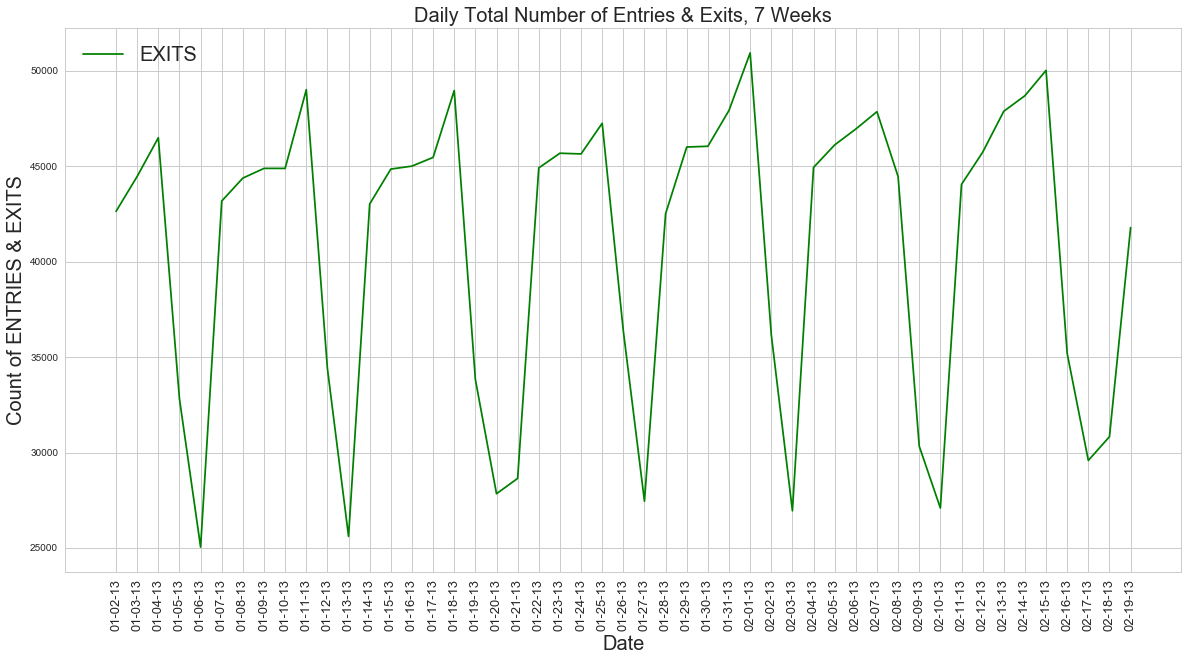

In [514]:
plt.figure(figsize=(20,10))
# 7 weeks data from AllBoth
data1AVE = AllBoth.loc[0][1:50]
y_pos = np.arange(len(data1AVE))
xticket = data1AVE.index
plt.plot(y_pos, data1AVE, '-g', label = 'EXITS')
plt.xticks(y_pos, xticket,fontsize = 10,rotation=90,size =13)
plt.legend(prop={'size':20})
plt.xlabel("Date",size=20)
plt.ylabel("Count of ENTRIES & EXITS",size=20)
plt.title("Daily Total Number of Entries & Exits, 7 Weeks",size=20)
plt.show()

## a) Calculate the Mean counts for each day in 2013

In [165]:
AllBothMean =  pd.DataFrame( columns=AllBoth.columns, dtype=float)
AllBothMean.loc[0] = AllBoth.mean().round(2)
AllBothMean.STATION = 'Mean'
AllBothMean

,STATION,01-02-13,01-03-13,01-04-13,01-05-13,01-06-13,01-07-13,01-08-13,01-09-13,01-10-13,01-11-13,01-12-13,01-13-13,01-14-13,01-15-13,01-16-13,01-17-13,01-18-13,01-19-13,01-20-13,01-21-13,01-22-13,01-23-13,01-24-13,01-25-13,01-26-13,01-27-13,01-28-13,01-29-13,01-30-13,01-31-13,02-01-13,02-02-13,02-03-13,02-04-13,02-05-13,02-06-13,02-07-13,02-08-13,02-09-13,02-10-13,02-11-13,02-12-13,02-13-13,02-14-13,02-15-13,02-16-13,02-17-13,02-18-13,02-19-13,02-20-13,02-21-13,02-22-13,02-23-13,02-24-13,02-25-13,02-26-13,02-27-13,02-28-13,03-01-13,03-02-13,03-03-13,03-04-13,03-05-13,03-06-13,03-07-13,03-08-13,03-09-13,03-10-13,03-11-13,03-12-13,03-13-13,03-14-13,03-15-13,03-16-13,03-17-13,03-18-13,03-19-13,03-20-13,03-21-13,03-22-13,03-23-13,03-24-13,03-25-13,03-26-13,03-27-13,03-28-13,03-29-13,03-30-13,03-31-13,04-01-13,04-02-13,04-03-13,04-04-13,04-05-13,04-06-13,04-07-13,04-08-13,04-09-13,04-10-13,04-11-13,04-12-13,04-13-13,04-14-13,04-15-13,04-16-13,04-17-13,04-18-13,04-19-13,04-20-13,04-21-13,04-22-13,04-23-13,04-24-13,04-25-13,04-26-13,04-27-13,04-28-13,04-29-13,04-30-13,05-01-13,05-02-13,05-03-13,05-04-13,05-05-13,05-06-13,05-07-13,05-08-13,05-09-13,05-10-13,05-11-13,05-12-13,05-13-13,05-14-13,05-15-13,05-16-13,05-17-13,05-18-13,05-19-13,05-20-13,05-21-13,05-22-13,05-23-13,05-24-13,05-25-13,05-26-13,05-27-13,05-28-13,05-29-13,05-30-13,05-31-13,06-01-13,06-02-13,06-03-13,06-04-13,06-05-13,06-06-13,06-07-13,06-08-13,06-09-13,06-10-13,06-11-13,06-12-13,06-13-13,06-14-13,06-15-13,06-16-13,06-17-13,06-18-13,06-19-13,06-20-13,06-21-13,06-22-13,06-23-13,06-24-13,06-25-13,06-26-13,06-27-13,06-28-13,06-29-13,06-30-13,07-01-13,07-02-13,07-03-13,07-04-13,07-05-13,07-06-13,07-07-13,07-08-13,07-09-13,07-10-13,07-11-13,07-12-13,07-13-13,07-14-13,07-15-13,07-16-13,07-17-13,07-18-13,07-19-13,07-20-13,07-21-13,07-22-13,07-23-13,07-24-13,07-25-13,07-26-13,07-27-13,07-28-13,07-29-13,07-30-13,07-31-13,08-01-13,08-02-13,08-03-13,08-04-13,08-05-13,08-06-13,08-07-13,08-08-13,08-09-13,08-10-13,08-11-13,08-12-13,08-13-13,08-14-13,08-15-13,08-16-13,08-17-13,08-18-13,08-19-13,08-20-13,08-21-13,08-22-13,08-23-13,08-24-13,08-25-13,08-26-13,08-27-13,08-28-13,08-29-13,08-30-13,08-31-13,09-01-13,09-02-13,09-03-13,09-04-13,09-05-13,09-06-13,09-07-13,09-08-13,09-09-13,09-10-13,09-11-13,09-12-13,09-13-13,09-14-13,09-15-13,09-16-13,09-17-13,09-18-13,09-19-13,09-20-13,09-21-13,09-22-13,09-23-13,09-24-13,09-25-13,09-26-13,09-27-13,09-28-13,09-29-13,09-30-13,10-01-13,10-02-13,10-03-13,10-04-13,10-05-13,10-06-13,10-07-13,10-08-13,10-09-13,10-10-13,10-11-13,10-12-13,10-13-13,10-14-13,10-15-13,10-16-13,10-17-13,10-18-13,10-19-13,10-20-13,10-21-13,10-22-13,10-23-13,10-24-13,10-25-13,10-26-13,10-27-13,10-28-13,10-29-13,10-30-13,10-31-13,11-01-13,11-02-13,11-03-13,11-04-13,11-05-13,11-06-13,11-07-13,11-08-13,11-09-13,11-10-13,11-11-13,11-12-13,11-13-13,11-14-13,11-15-13,11-16-13,11-17-13,11-18-13,11-19-13,11-20-13,11-21-13,11-22-13,11-23-13,11-24-13,11-25-13,11-26-13,11-27-13,11-28-13,11-29-13,11-30-13,12-01-13,12-02-13,12-03-13,12-04-13,12-05-13,12-06-13,12-07-13,12-08-13,12-09-13,12-10-13,12-11-13,12-12-13,12-13-13,12-14-13,12-15-13,12-16-13,12-17-13,12-18-13,12-19-13,12-20-13,12-21-13,12-22-13,12-23-13,12-24-13,12-25-13,12-26-13,12-27-13,12-28-13,12-29-13,12-30-13,12-31-13
0,Mean,31468.09,27536.86,27470.26,15784.34,12899.41,26993.58,27591.74,27681.33,27872.13,27718.22,16483.38,12459.19,26755.68,28527.74,28472.5,28063.21,29309.69,15662.33,12534.03,16580.77,26916.55,26241.77,27011.32,26394.05,16335.59,11931.86,26931.01,29045.32,29164.04,31537.02,28940.44,15994.74,11905.15,27949.07,28683.43,29151.69,29450.86,24011.21,11928.94,12459.35,27619.39,28594.07,30743.88,30055.78,28973.94,16441.99,12961.1,16595.79,26836.44,28829.72,28794.95,28652.39,15191.37,12183.22,27921.17,28853.09,28662.63,29229.58,29115.36,16808.05,12849.79,28527.34,29461.21,29467.63,28829.57,27475.91,17391.56,12698.23,28600.08,28436.15,29790.4,29809.56,29506.29,17180.69,13363.97,27899.03,28973.14,29129.35,28971.02,

## b) Calculate the Mean and Std for Sunday Through Saturday

### i. Create a Dictionary Containing Groups of Dates for each Weekday
>  The key is index represent weekdays, the values is dates match that weekday index.

In [468]:
start = date(2013, 1, 2)
end = date(2013, 12, 31)
dateList = createDateList(start, end)

diction = {}
for day in dateList:
    idx = datetime.strptime(day,'%m-%d-%y').weekday()
    if idx in diction:
        diction[idx] += [day]
    else:
        diction[idx] = ["STATION",day]

In [471]:
# Show some dates that is Monday
diction[0][:5]

['STATION', '01-07-13', '01-14-13', '01-21-13', '01-28-13']

In [472]:
# Show some dates that is Tuesday
diction[1][:5]

['STATION', '01-08-13', '01-15-13', '01-22-13', '01-29-13']

### ii. Calculate the Mean Table and Std Table

In [473]:
# calculate weekday mean
weekdayMean = AllBothMean[['STATION']]
weekdaydict = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    mean = AllBothMean.loc[:, diction[i]].mean(axis = 1).round(2)
    weekdayMean[weekdaydict[i]] = mean

# calculate weekday std
weekdayStd = AllBothMean[['STATION']]
weekdayStd.STATION = 'Std'
weekdaydict = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    std = AllBothMean.loc[:,diction[i]].std(axis = 1).round(2)
    weekdayStd[weekdaydict[i]] = std

In [474]:
weekdayMean

,STATION,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,Mean,26622.91,28729.95,28762.77,28293.74,28034.83,17184.25,13453.47


In [476]:
weekdayStd

,STATION,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,Std,3698.25,2812.17,3071.69,3577.75,2307.49,2178.44,788.74


## Example: How This Work on Friday's Data
> From the plot we can see that Jul 5th and Nov 29th are two std below the mean, Feb 8th, Mar 29th and Dec 27th are one std below the mean. It's possible that some stations are not operating at full capacity during these dates 

In [416]:
def findDateOfOneWeekday(dateList, weekday):
    """
    :type dateList: date list, string list
    :type weekday: 0-7, 0 is Monday, 7 is Sunday
    :rtype: all Monday's count, list
    :rtype: all Monday's date, list
    
    Give a dateList, and weekday, This function will find
    all dates in the dateList that is the weekday you want 
    """
    data = []
    label = []
    weekdaydict = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
    for day in dateList:
        idx = datetime.strptime(day,'%m-%d-%y').weekday()
        if idx == weekday:
            data.append(AllBothMean.loc[:,day])
            label.append(day)
    return data, label

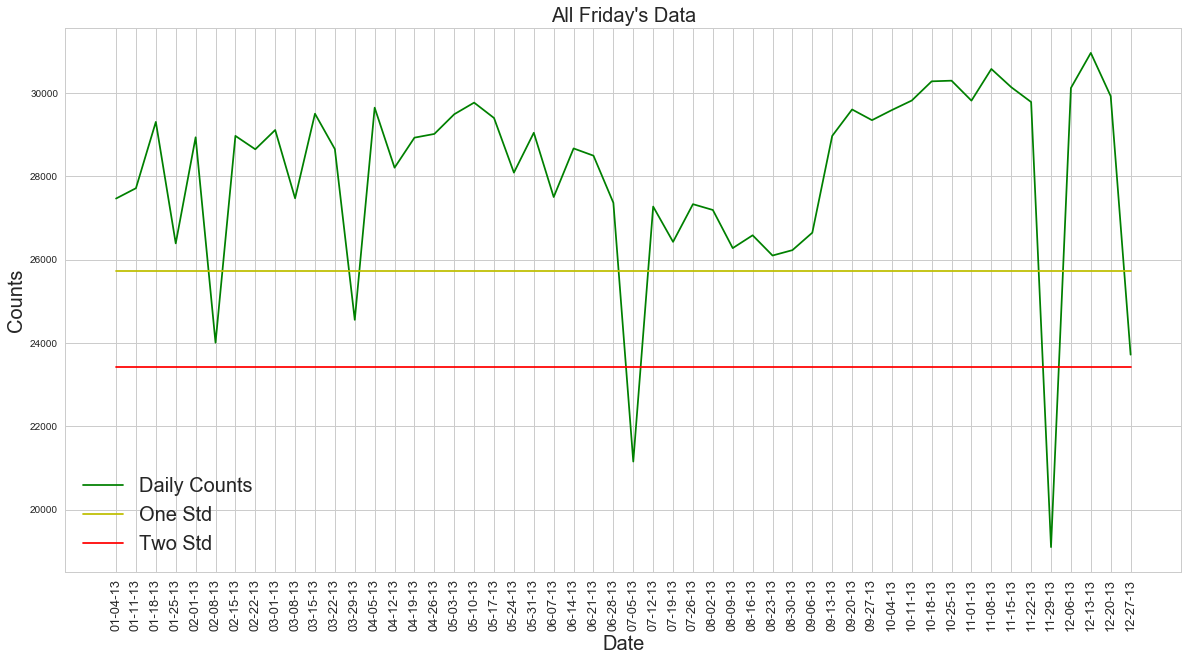

In [500]:
# test on Friday
FridayData, MondayLabel = findDateOfOneWeekday(dateList, 4)
# 1 std lower bound
lower1 = [weekdayMean['Fri'] - 1*weekdayStd['Fri']]*len(FridayData)
# 2 std lower bound
lower2 = [weekdayMean['Fri'] - 2*weekdayStd['Fri']]*len(FridayData)

plt.figure(figsize=(20,10))
data1AVE = AllBoth.loc[0][1:50]
y_pos = np.arange(len(MondayData))
xticket = MondayLabel
plt.plot(y_pos, FridayData, '-g', label = 'Daily Counts')
plt.plot(y_pos, lower1, '-y', label = 'One Std')
plt.plot(y_pos, lower2, '-r', label = 'Two Std')

plt.xticks(y_pos, xticket,fontsize = 10,rotation=90,size =13)
plt.legend(prop={'size':20})
plt.xlabel("Date",size = 20)
plt.ylabel("Counts",size=20)
plt.title("All Friday's Data", size = 20)
plt.show()

## c) Iterate Through Each Date in 2013
* checkClosed(dateList, scalar)
    * This function will check outliers based on a given scalar
    * The scalar will be multiplied by the std, it indicates the tolerance we choose to find the outliers.

In [482]:
def checkClosed(dateList, scalar):
    """
    :type dateList: date list, string list
    :type scalar: tolerance, std multiplier
    :rtype: dictionary, key is date, value is closed station number
    
    """
    output = {}
    weekdaydict = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
    for day in dateList:
        # get day's weekday index
        idx = datetime.strptime(day,'%m-%d-%y').weekday()
        # get day's count
        currentDayCount = AllBothMean.loc[:,day]
        # get corresponding weekday's mean and std
        currentDayStandardMean =  weekdayMean[weekdaydict[idx]]
        currentDayStandardStd = weekdayStd[weekdaydict[idx]]
        # below the bound
        check = (currentDayCount < currentDayStandardMean- scalar*currentDayStandardStd)
        # only return the date that have >1 stations closed
        if sum(check)>0:
            output[day] = [ weekdaydict[idx], 'Counts: %d' % float(currentDayCount),\
                           'Mean counts on %s: %d' % (weekdaydict[idx],float(currentDayStandardMean))]
    return output

#### When Scalar = 1, which means the tolerance is 1 std
> The following date is possible to have some stations closed/not full capacity

In [484]:
start = date(2013, 1, 2)
end = date(2013, 12, 31)
dateList = createDateList(start, end)
checkClosed(dateList, 1)

{'01-13-13': ['Sun', 'Counts: 12459', 'Mean counts on Sun: 13453'],
 '01-20-13': ['Sun', 'Counts: 12534', 'Mean counts on Sun: 13453'],
 '01-21-13': ['Mon', 'Counts: 16580', 'Mean counts on Mon: 26622'],
 '01-27-13': ['Sun', 'Counts: 11931', 'Mean counts on Sun: 13453'],
 '02-03-13': ['Sun', 'Counts: 11905', 'Mean counts on Sun: 13453'],
 '02-08-13': ['Fri', 'Counts: 24011', 'Mean counts on Fri: 28034'],
 '02-09-13': ['Sat', 'Counts: 11928', 'Mean counts on Sat: 17184'],
 '02-10-13': ['Sun', 'Counts: 12459', 'Mean counts on Sun: 13453'],
 '02-18-13': ['Mon', 'Counts: 16595', 'Mean counts on Mon: 26622'],
 '02-24-13': ['Sun', 'Counts: 12183', 'Mean counts on Sun: 13453'],
 '03-29-13': ['Fri', 'Counts: 24558', 'Mean counts on Fri: 28034'],
 '03-31-13': ['Sun', 'Counts: 12437', 'Mean counts on Sun: 13453'],
 '05-27-13': ['Mon', 'Counts: 14229', 'Mean counts on Mon: 26622'],
 '07-04-13': ['Thu', 'Counts: 14334', 'Mean counts on Thu: 28293'],
 '07-05-13': ['Fri', 'Counts: 21157', 'Mean coun

#### When Scalar = 2, which means the tolerance is 2 std
> The following date is possible to have some stations closed/not full capacity. As you can see, compared to $ scalar = 1$, fewer dates are identified as closed or not full capacity.

In [490]:
start = date(2013, 1, 2)
end = date(2013, 12, 31)
dateList = createDateList(start, end)
checkClosed(dateList, 2)

{'01-21-13': ['Mon', 'Counts: 16580', 'Mean counts on Mon: 26622'],
 '02-09-13': ['Sat', 'Counts: 11928', 'Mean counts on Sat: 17184'],
 '02-18-13': ['Mon', 'Counts: 16595', 'Mean counts on Mon: 26622'],
 '05-27-13': ['Mon', 'Counts: 14229', 'Mean counts on Mon: 26622'],
 '07-04-13': ['Thu', 'Counts: 14334', 'Mean counts on Thu: 28293'],
 '07-05-13': ['Fri', 'Counts: 21157', 'Mean counts on Fri: 28034'],
 '09-02-13': ['Mon', 'Counts: 12951', 'Mean counts on Mon: 26622'],
 '11-28-13': ['Thu', 'Counts: 11239', 'Mean counts on Thu: 28293'],
 '11-29-13': ['Fri', 'Counts: 19105', 'Mean counts on Fri: 28034'],
 '12-24-13': ['Tue', 'Counts: 20959', 'Mean counts on Tue: 28729'],
 '12-25-13': ['Wed', 'Counts: 9117', 'Mean counts on Wed: 28762']}

#### When Scalar = 3, which means the tolerance is  std
> The following date is possible to have some stations closed/not full capacity. As you can see, compared to $ scalar = 1 \& 2$, fewer dates are identified as closed or not full capacity.

In [491]:
start = date(2013, 1, 2)
end = date(2013, 12, 31)
dateList = createDateList(start, end)
checkClosed(dateList, 3)

{'05-27-13': ['Mon', 'Counts: 14229', 'Mean counts on Mon: 26622'],
 '07-04-13': ['Thu', 'Counts: 14334', 'Mean counts on Thu: 28293'],
 '09-02-13': ['Mon', 'Counts: 12951', 'Mean counts on Mon: 26622'],
 '11-28-13': ['Thu', 'Counts: 11239', 'Mean counts on Thu: 28293'],
 '11-29-13': ['Fri', 'Counts: 19105', 'Mean counts on Fri: 28034'],
 '12-25-13': ['Wed', 'Counts: 9117', 'Mean counts on Wed: 28762']}

# Part II Visualization

#  Problem 1
## Plot the daily row counts for data files in Q3 2013

# Process:
1. Since in the raw data, one line could contain data of multiple days, we will slice the raw data and keep all the rows contains whichever date among '07-01-13' to '09-30-13'.
2. Create a dictionary to count times of appearing of a date

## a) Find the min index and max index

In [554]:
# load raw data of 2013
year2013 = pickle.load( open( "year2013.p", "rb" ) )
year2013 = year2013.reset_index(drop = True)

In [555]:
# get start index of Q3
minidx = year2013[(year2013.DATE6 == '07-01-13')|(year2013.DATE7 == '07-01-13')| (year2013.DATE8 == '07-01-13')].index.min()

In [556]:
# get end index of Q3
maxidx = year2013[(year2013.DATE1 == '09-30-13')|(year2013.DATE2 == '09-30-13')| (year2013.DATE3 == '09-30-13')].index.max()

In [557]:
RawQ3 = year2013.iloc[minidx:maxidx+1].reset_index(drop=True)

In [558]:
RawQ3.head(2)

,C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8
0,A002,R051,02-00-00,06-30-13,08:00:00,REGULAR,4175457,1433928,06-30-13,12:00:00,REGULAR,4175520.0,1433981.0,06-30-13,16:00:00,REGULAR,4175708.0,1434026.0,06-30-13,20:00:00,REGULAR,4175899.0,1434075.0,07-01-13,00:00:00,REGULAR,4175981.0,1434096.0,07-01-13,04:00:00,REGULAR,4175994.0,1434101.0,07-01-13,08:00:00,REGULAR,4176047.0,1434181.0,07-01-13,12:00:00,REGULAR,4176214.0,1434391.0
1,A002,R051,02-00-00,07-01-13,16:00:00,REGULAR,4176441,1434437,07-01-13,20:00:00,REGULAR,4177239.0,1434503.0,07-02-13,00:00:00,REGULAR,4177437.0,1434522.0,07-02-13,04:00:00,REGULAR,4177449.0,1434524.0,07-02-13,08:00:00,REGULAR,4177488.0,1434617.0,07-02-13,12:00:00,REGULAR,4177663.0,1434852.0,07-02-13,16:00:00,REGULAR,4177928.0,1434922.0,07-02-13,20:00:00,REGULAR,4178824.0,1434971.0


## b) Count the Appearing Times
>Notice that '07-01-13' appear in first row and second row, so it will be count twice.`m

In [559]:
dailyRowCount = RawQ3[['DATE1','DATE2','DATE3','DATE4','DATE5','DATE6','DATE7','DATE8']]
dailyRowCount.head(2)

,DATE1,DATE2,DATE3,DATE4,DATE5,DATE6,DATE7,DATE8
0,06-30-13,06-30-13,06-30-13,06-30-13,07-01-13,07-01-13,07-01-13,07-01-13
1,07-01-13,07-01-13,07-02-13,07-02-13,07-02-13,07-02-13,07-02-13,07-02-13


In [560]:
# count each date appeared how many rows
diction = {}
for i in range(len(dailyRowCount)):
    tmp = set()
    for j in range(1,9):
        tmp.add(dailyRowCount.loc[i, 'DATE'+str(j)])
        for x in list(tmp):
            if (x in diction):
                diction[x] += 1
            elif str(x)!='nan':
                diction[x] = 1

In [561]:
diction['07-01-13']

54456

In [562]:
# Delete items that out of range
del diction['06-29-13']
del diction['06-30-13']
del diction['10-01-13']
del diction['10-02-13']
del diction['10-03-13']
del diction['10-04-13']

In [563]:
# x, y in the plot
keys = diction.keys()
values = diction.values()

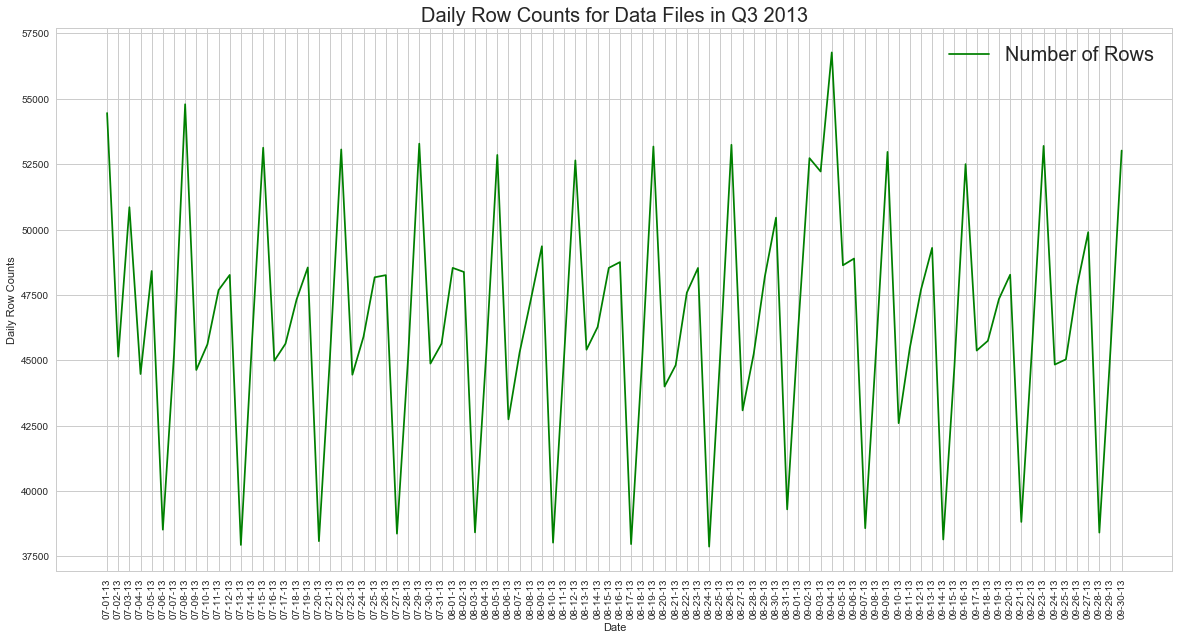

In [564]:
plt.figure(figsize=(20,10))
y_pos = np.arange(len(keys))
xticket = keys
plt.plot(y_pos, list(values), '-g', label = 'Number of Rows')
plt.xticks(y_pos, xticket,fontsize = 10,rotation=90)
plt.legend(prop={'size':20})
plt.xlabel("Date")
plt.ylabel("Daily Row Counts")
plt.title("Daily Row Counts for Data Files in Q3 2013",size = 20)
plt.show()

As shown in the plot above, daily row counts shows weekly periodic change except week Sep 1 - 7, in which there's more row counts in the first two days.

# Problem 2
### Plot the daily total number of entries & exits across the system for Q3 2013.

## a) Separate Counts Data to Entries Data and Exits Data

In [521]:
All = pickle.load( open( "CountByStationAllYear_redressed.p", "rb" ) )

In [522]:
# sum of counts for ENTRIES & EXITS
sumed = All.sum()[1:]
# get the ENTIRES data
sumEn = sumed[360:543:2]
# get the EXITS data
sumEx = sumed[361:544:2]

In [524]:
# sample ENTRIES data
sumEn[:5]

07-01-13EN     4.6268e+06
07-02-13EN    4.89644e+06
07-03-13EN    4.87907e+06
07-04-13EN    2.53727e+06
07-05-13EN    3.74822e+06
dtype: object

## b) Plot Both Entries Data and Exits Data

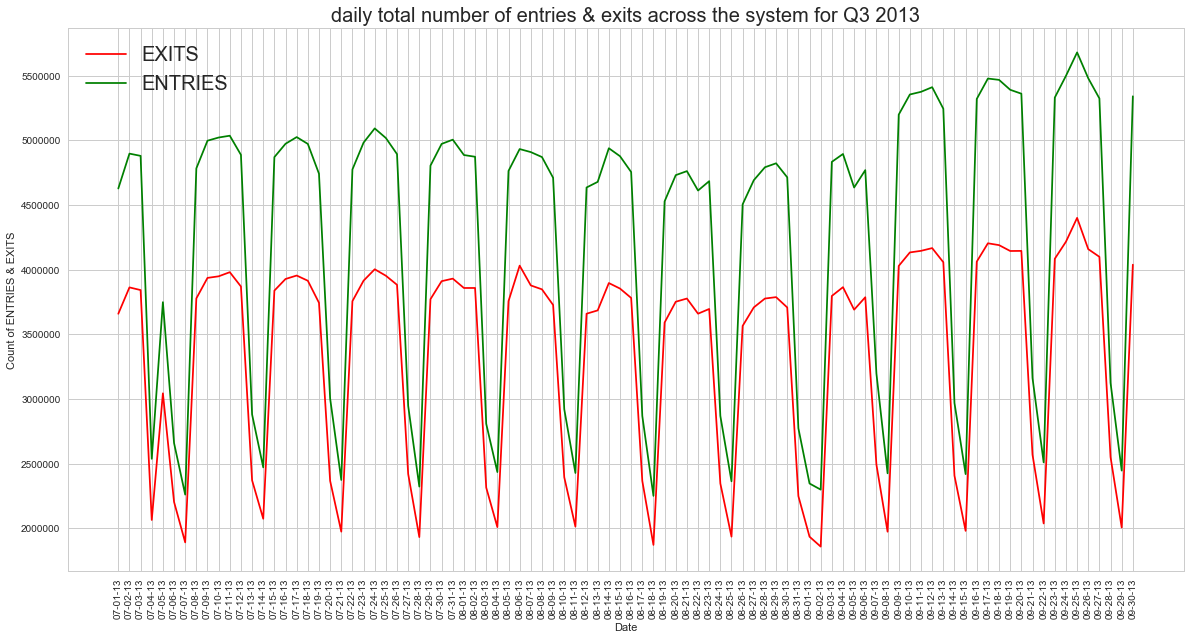

In [527]:
plt.figure(figsize=(20,10))
y_pos = np.arange(len(sumEx))
xticket = map(lambda x: x[:-2],sumEx.index)
plt.plot(y_pos, sumEx, '-r', label = 'EXITS')
plt.plot(y_pos, sumEn, '-g', label = 'ENTRIES')
plt.xticks(y_pos, xticket,fontsize = 10,rotation=90)
plt.legend(prop={'size':20})
plt.xlabel("Date")
plt.ylabel("Count of ENTRIES & EXITS")
plt.title("daily total number of entries & exits across the system for Q3 2013", size = 20)
plt.show()

From the plot above we can see that for both ENTRIES & EXITS, the counts show weekly periodic change, except July 4th, there's much fewer people than expected. Besides, both counts is larger in September. Finally, all counts for ENTRIES is larger than that of EXITS, we do not know the reason, but when take a look at the raw data, we find the counts for EXITS is indeed lower for most of the days.

# Problem 3
## Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA

## a) Get Data for Station 34 ST-PENN STA

In [529]:
# keep only data for 34 ST station, in Q3 2013
PennSTA = All.loc[All.STATION == '34 ST-PENN STA','07-01-13EN':'09-30-13EX'].reset_index(drop=True)
PennSTA

,07-01-13EN,07-01-13EX,07-02-13EN,07-02-13EX,07-03-13EN,07-03-13EX,07-04-13EN,07-04-13EX,07-05-13EN,07-05-13EX,07-06-13EN,07-06-13EX,07-07-13EN,07-07-13EX,07-08-13EN,07-08-13EX,07-09-13EN,07-09-13EX,07-10-13EN,07-10-13EX,07-11-13EN,07-11-13EX,07-12-13EN,07-12-13EX,07-13-13EN,07-13-13EX,07-14-13EN,07-14-13EX,07-15-13EN,07-15-13EX,07-16-13EN,07-16-13EX,07-17-13EN,07-17-13EX,07-18-13EN,07-18-13EX,07-19-13EN,07-19-13EX,07-20-13EN,07-20-13EX,07-21-13EN,07-21-13EX,07-22-13EN,07-22-13EX,07-23-13EN,07-23-13EX,07-24-13EN,07-24-13EX,07-25-13EN,07-25-13EX,07-26-13EN,07-26-13EX,07-27-13EN,07-27-13EX,07-28-13EN,07-28-13EX,07-29-13EN,07-29-13EX,07-30-13EN,07-30-13EX,07-31-13EN,07-31-13EX,08-01-13EN,08-01-13EX,08-02-13EN,08-02-13EX,08-03-13EN,08-03-13EX,08-04-13EN,08-04-13EX,08-05-13EN,08-05-13EX,08-06-13EN,08-06-13EX,08-07-13EN,08-07-13EX,08-08-13EN,08-08-13EX,08-09-13EN,08-09-13EX,08-10-13EN,08-10-13EX,08-11-13EN,08-11-13EX,08-12-13EN,08-12-13EX,08-13-13EN,08-13-13EX,08-14-13EN,08-14-13EX,08-15-13EN,08-15-13EX,08-16-13EN,08-16-13EX,08-17-13EN,08-17-13EX,08-18-13EN,08-18-13EX,08-19-13EN,08-19-13EX,08-20-13EN,08-20-13EX,08-21-13EN,08-21-13EX,08-22-13EN,08-22-13EX,08-23-13EN,08-23-13EX,08-24-13EN,08-24-13EX,08-25-13EN,08-25-13EX,08-26-13EN,08-26-13EX,08-27-13EN,08-27-13EX,08-28-13EN,08-28-13EX,08-29-13EN,08-29-13EX,08-30-13EN,08-30-13EX,08-31-13EN,08-31-13EX,09-01-13EN,09-01-13EX,09-02-13EN,09-02-13EX,09-03-13EN,09-03-13EX,09-04-13EN,09-04-13EX,09-05-13EN,09-05-13EX,09-06-13EN,09-06-13EX,09-07-13EN,09-07-13EX,09-08-13EN,09-08-13EX,09-09-13EN,09-09-13EX,09-10-13EN,09-10-13EX,09-11-13EN,09-11-13EX,09-12-13EN,09-12-13EX,09-13-13EN,09-13-13EX,09-14-13EN,09-14-13EX,09-15-13EN,09-15-13EX,09-16-13EN,09-16-13EX,09-17-13EN,09-17-13EX,09-18-13EN,09-18-13EX,09-19-13EN,09-19-13EX,09-20-13EN,09-20-13EX,09-21-13EN,09-21-13EX,09-22-13EN,09-22-13EX,09-23-13EN,09-23-13EX,09-24-13EN,09-24-13EX,09-25-13EN,09-25-13EX,09-26-13EN,09-26-13EX,09-27-13EN,09-27-13EX,09-28-13EN,09-28-13EX,09-29-13EN,09-29-13EX,09-30-13EN,09-30-13EX
0,171235.0,146102.0,173955.0,151615.0,168403.0,165093.0,79503.0,87037.0,121264.0,110944.0,79432.0,74964.0,80969.0,60705.0,172193.0,142251.0,175302.0,151061.0,174431.0,149996.0,175894.0,150544.0,172002.0,163567.0,86980.0,84151.0,11825.0,10792.0,175681.0,148795.0,174031.0,150530.0,174579.0,150499.0,174309.0,152268.0,166507.0,155721.0,80550.0,80400.0,78616.0,67111.0,172948.0,143826.0,174586.0,149155.0,178106.0,156323.0,174028.0,153780.0,167160.0,157099.0,85484.0,83652.0,78860.0,63195.0,169796.0,142816.0,172190.0,147889.0,172785.0,150383.0,172502.0,154242.0,162686.0,153789.0,79063.0,74326.0,78863.0,64501.0,162018.0,133901.0,167068.0,146122.0,170496.0,148404.0,171544.0,151723.0,161702.0,150878.0,83486.0,80235.0,78039.0,65198.0,168750.0,138368.0,167226.0,141638.0,169933.0,148061.0,167640.0,148010.0,182836.0,178147.0,77433.0,78417.0,70005.0,60581.0,159813.0,137040.0,164108.0,142762.0,163799.0,143853.0,161892.0,142237.0,152216.0,144420.0,76000.0,75077.0,70209.0,59142.0,157646.0,133484.0,161598.0,139631.0,162095.0,143285.0,162659.0,144565.0,150910.0,144917.0,75490.0,77877.0,65347.0,62847.0,75929.0,61139.0,166677.0,139439.0,164872.0,149465.0,155669.0,137553.0,162590.0,145311.0,87575.0,81621.0,74287.0,63739.0,168408.0,141952.0,172882.0,150100.0,172476.0,150069.0,177848.0,156224.0,166266.0,156753.0,79067.0,73477.0,71029.0,58026.0,175569.0,146377.0,178542.0,153560.0,177196.0,153017.0,173384.0,151279.0,170428.0,154615.0,85788.0,79564.0,73874.0,64063.0,173267.0,146462.0,175636.0,153053.0,175469.0,151619.0,174226.0,150176.0,169708.0,153406.0,88921.0,83591.0,71648.0,64984.0,170669.0,143991.0


## b)  Calculate Mean and Std for Entries and Exits by Month

In [530]:
# split by month/Entries or Exits
JulEn = PennSTA.loc[0,'06-30':'07-31-13EN':2]
AugEn = PennSTA.loc[0,'08-01-13EN':'08-31-13EN':2]
SepEn = PennSTA.loc[0,'09-01-13EN':'09-30-13EN':2]

JulEx = PennSTA.loc[0,'07-01-13EX':'07-31-13EX':2]
AugEx = PennSTA.loc[0,'08-01-13EX':'08-31-13EX':2]
SepEx = PennSTA.loc[0,'09-01-13EX':'09-30-13EX':2]

In [531]:
# get mean and std for each month/Entries or Exits
stdlist = [np.std(JulEn),np.std(JulEx), np.std(AugEn),np.std(AugEx), np.std(SepEn), np.std(SepEx)]
meanlist = [np.mean(JulEn),np.mean(JulEx), np.mean(AugEn), np.mean(AugEx), np.mean(SepEn), np.mean(SepEx)]
monthlist = ['July Entry','July Exit','August Entry','August Exit','September Entry','September Exit']

In [532]:
raw_data = {'Month': monthlist,'Mean': meanlist,'Std': stdlist}
df = pd.DataFrame(raw_data, columns = ['Month', 'Mean', 'Std'])
df

,Month,Mean,Std
0,July Entry,142374.322581,46521.760692
1,July Exit,125879.483871,39820.362283
2,August Entry,139023.387097,40445.533004
3,August Exit,124026.806452,35250.693325
4,September Entry,139841.566667,44632.444526
5,September Exit,122582.400000,38263.988171


## c) Plot with Bar Chart

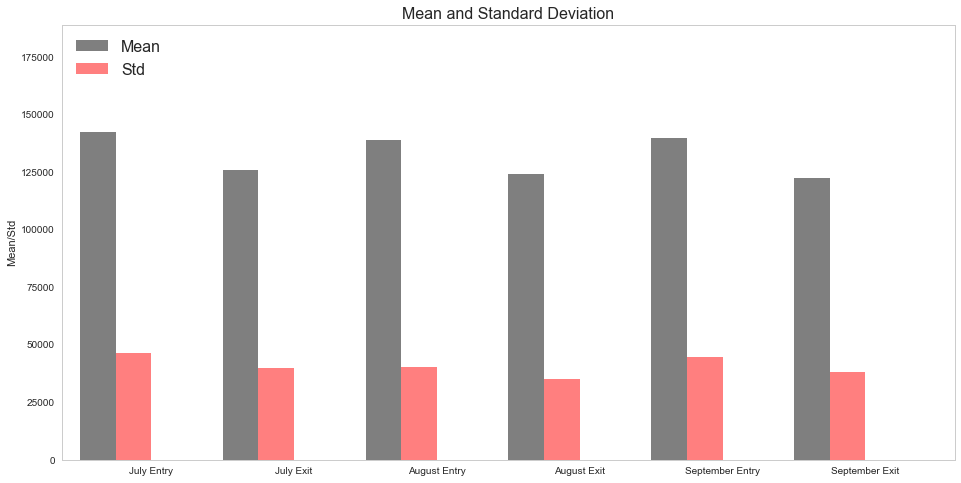

In [533]:
# Setting the positions and width for the bars
# reference: https://chrisalbon.com/python/matplotlib_grouped_bar_plot.html
pos = list(range(len(df['Mean'])))
width = 0.25
# Plotting the bars
fig, ax = plt.subplots(figsize=(16,8))
# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar(pos,
        #using df['pre_score'] data,
        df['Mean'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='Black',
        # with label the first value in first_name
        label=df['Month'][0])

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos],
        #using df['mid_score'] data,
        df['Std'],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='Red',
        # with label the second value in first_name
        label=df['Month'][1])

# Set the y axis label
ax.set_ylabel('Mean/Std')

# Set the chart's title
ax.set_title('Mean and Standard Deviation',size = 16)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['Month'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df['Mean'] + df['Std'])] )

# Adding the legend and showing the plot
plt.legend(['Mean', 'Std'], loc='upper left',prop={'size':16})
plt.grid()
plt.show()

From the plot we can see that the counts decreased slightly from July to September.

# Problem 4
## Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA

## Plot I.  Boxplot with Seaborn Package

In [534]:
# format the data to fit in sns.boxplot function
PennSTA = All.loc[All.STATION == '34 ST-PENN STA','07-01-13EN':'09-30-13EX'].sum()
month = pd.Series(map(lambda x: x[:2], PennSTA.index))
direct = pd.Series(map(lambda x: x[-2:], PennSTA.index))
PennSTA = PennSTA.reset_index()
PennSTA['Month'] = month
PennSTA['Direction'] = direct
PennSTA.rename(columns={0:'Counts'}, inplace = True)
PennSTA.head()

,index,Counts,Month,Direction
0,07-01-13EN,171235.0,07,EN
1,07-01-13EX,146102.0,07,EX
2,07-02-13EN,173955.0,07,EN
3,07-02-13EX,151615.0,07,EX
4,07-03-13EN,168403.0,07,EN


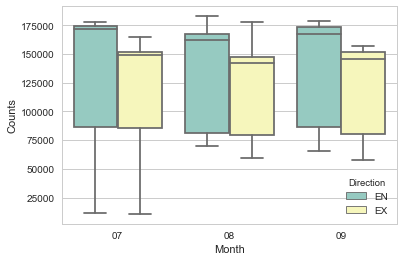

In [535]:
ax = sns.boxplot(x="Month", y="Counts", hue="Direction",  data=PennSTA, palette="Set3", fliersize=16)

The plot shows that three group of counts have long left tail, as the median is very closed to the thrid quantile. Besides, in July, the lowest point is almost reached 10000, that's probably the July 4th.

## Plot II.  Boxplot with Matplotlib Package

In [536]:
cols = [JulEn,JulEx,AugEn,AugEx,SepEn,SepEx]
# quantile list for JulEn,JulEx,AugEn,AugEx,SepEn,SepEx
dataQuantile = []
for i in range(len(cols)):
    dataQuantile.append(list(cols[i].quantile([0, .25, .5, .75,1])))
dataQuantile

[[11825.0, 86232.0, 172002.0, 174170.0, 178106.0],
 [10792.0, 85594.0, 148795.0, 151338.0, 165093.0],
 [70005.0, 81274.5, 161892.0, 167147.0, 182836.0],
 [59142.0, 79326.0, 142237.0, 147066.0, 178147.0],
 [65347.0, 86234.75, 167542.5, 173354.75, 178542.0],
 [58026.0, 80078.25, 145844.0, 151534.0, 156753.0]]

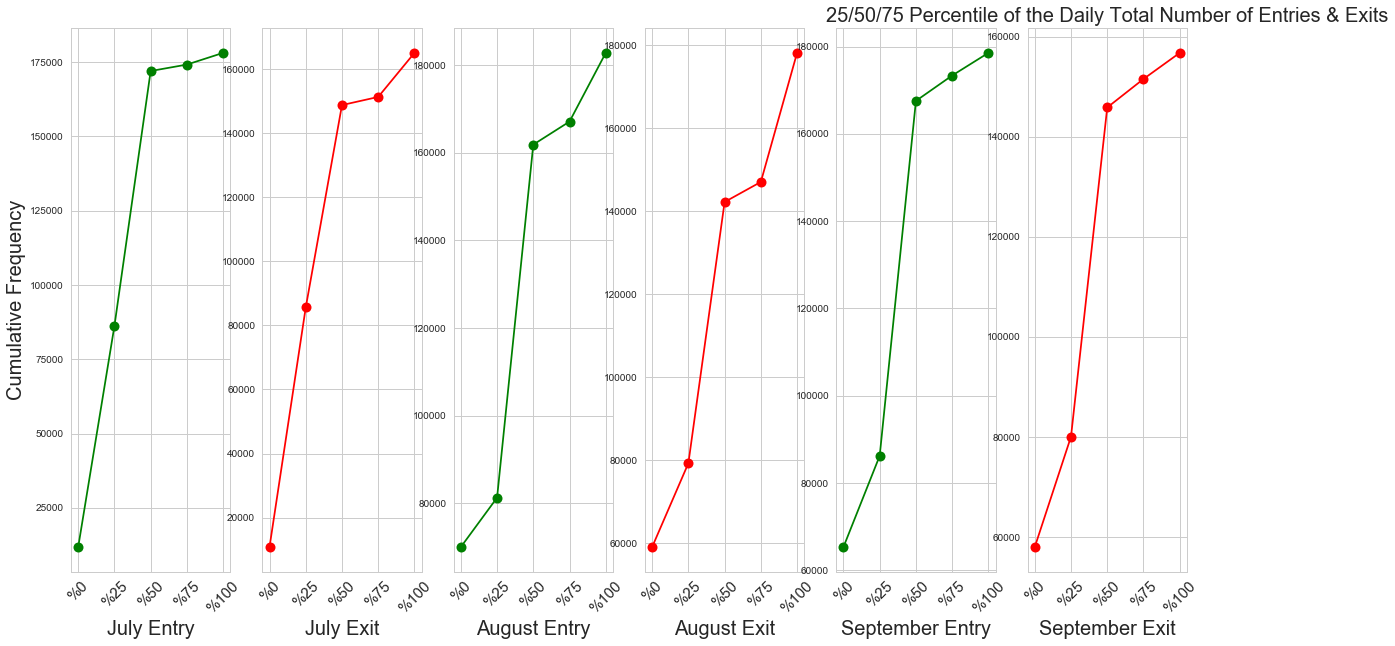

In [537]:
import itertools

fig, axes = plt.subplots(nrows=1, ncols=6,figsize=(20,10))
colors = itertools.cycle(['g', 'r'])
for ax, data, color in zip(axes, dataQuantile, colors):
    ax.plot(range(5), data, color=color,marker='o', markersize=10, linestyle='-')
    ax.set_xticks(range(5))
    ax.set_xticklabels(['%0','%25','%50','%75','%100'], rotation=45,size=15)

axes[0].set_ylabel('Cumulative Frequency',size=20)
monthlist = ['July Entry','July Exit','August Entry','August Exit','September Entry','September Exit']
for ax, label in zip(axes, monthlist):
    ax.set_xlabel(label,size=20)

plt.title("25/50/75 Percentile of the Daily Total Number of Entries & Exits",size = 20)
plt.show()

These plots show the same result, median is very closed to third quantiles, indicating that the counts is left tailed.

# Problem 5
## Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

# Process:
> This Problem is similar to Problem 5 in Part I, the difference is we will calculate the mean and std for each station, not the sum, according to the weekdays.

>1. Calculate the Mean and Std for each station grouped by weekdays, Sunday Through Saturday

>2. Iterate through every day in 2013, compare its count to the $mean - scalar\cdot std$ according to which weekday it is


## a) Get the Sum of Counts for ENTIRES & EXITS

In [538]:
def createDateList(start, end):
    """
    :type start: datetime.date type
    :type end: datetime.date type
    :rtype: list of string
    
    """
    def daterange(date1, date2):
        for n in range(int ((date2 - date1).days)+1):
            yield date1 + timedelta(n)
    return [dt.strftime("%m-%d-%y") for dt in daterange(start, end)]

In [539]:
# all entry counts and exit counts for each day
start = date(2013, 7, 1)
end = date(2013, 9, 30)
dateList = createDateList(start, end)
AllBoth = All[['STATION']]
for day in dateList:
    AllBoth[day] = All[day+'EN']+All[day+'EX']

In [540]:
AllBoth.head()

,STATION,07-01-13,07-02-13,07-03-13,07-04-13,07-05-13,07-06-13,07-07-13,07-08-13,07-09-13,07-10-13,07-11-13,07-12-13,07-13-13,07-14-13,07-15-13,07-16-13,07-17-13,07-18-13,07-19-13,07-20-13,07-21-13,07-22-13,07-23-13,07-24-13,07-25-13,07-26-13,07-27-13,07-28-13,07-29-13,07-30-13,07-31-13,08-01-13,08-02-13,08-03-13,08-04-13,08-05-13,08-06-13,08-07-13,08-08-13,08-09-13,08-10-13,08-11-13,08-12-13,08-13-13,08-14-13,08-15-13,08-16-13,08-17-13,08-18-13,08-19-13,08-20-13,08-21-13,08-22-13,08-23-13,08-24-13,08-25-13,08-26-13,08-27-13,08-28-13,08-29-13,08-30-13,08-31-13,09-01-13,09-02-13,09-03-13,09-04-13,09-05-13,09-06-13,09-07-13,09-08-13,09-09-13,09-10-13,09-11-13,09-12-13,09-13-13,09-14-13,09-15-13,09-16-13,09-17-13,09-18-13,09-19-13,09-20-13,09-21-13,09-22-13,09-23-13,09-24-13,09-25-13,09-26-13,09-27-13,09-28-13,09-29-13,09-30-13
0,1 AVE,42864.0,45245.0,45889.0,30923.0,39758.0,32004.0,28036.0,42390.0,45190.0,46747.0,47158.0,50230.0,38893.0,32455.0,43142.0,45388.0,46064.0,46774.0,48438.0,38550.0,31518.0,43115.0,45203.0,46841.0,46995.0,48452.0,40594.0,30879.0,43043.0,45092.0,45578.0,43850.0,46409.0,37764.0,31749.0,42252.0,43686.0,44896.0,45656.0,46517.0,36669.0,29790.0,41587.0,43080.0,44706.0,45195.0,46481.0,36407.0,29935.0,40771.0,42919.0,43229.0,43362.0,45194.0,29818.0,24570.0,40174.0,42839.0,44333.0,44100.0,44894.0,30453.0,25977.0,24575.0,42114.0,43803.0,43684.0,47409.0,37090.0,28690.0,46380.0,49083.0,49582.0,50180.0,53136.0,35331.0,27290.0,47500.0,49375.0,50248.0,49988.0,53758.0,40770.0,32295.0,47399.0,48936.0,49777.0,50104.0,52853.0,36859.0,28117.0,46047.0
1,103 ST,47065.0,49338.0,48809.0,27980.0,38967.0,28483.0,24363.0,48002.0,51592.0,50674.0,51068.0,50757.0,31184.0,27952.0,50521.0,50932.0,52291.0,51585.0,49766.0,31035.0,26419.0,49060.0,52169.0,53054.0,51456.0,50458.0,33012.0,27126.0,49478.0,51168.0,50299.0,51155.0,50683.0,31442.0,26050.0,48045.0,49575.0,49417.0,50212.0,48436.0,31347.0,26699.0,46669.0,48376.0,47551.0,48300.0,48634.0,30951.0,26480.0,45676.0,48188.0,47580.0,47155.0,46329.0,31567.0,26686.0,45201.0,47171.0,48147.0,48131.0,47895.0,30285.0,24988.0,25371.0,48828.0,49866.0,47352.0,50065.0,33302.0,28810.0,55054.0,56803.0,56226.0,56949.0,55786.0,33222.0,28364.0,55953.0,58102.0,57848.0,56963.0,56829.0,36220.0,28851.0,56985.0,57824.0,57954.0,57288.0,57122.0,32739.0,25582.0,54978.0
2,103 ST-CORONA,30166.0,32644.0,33743.0,22656.0,30217.0,17996.0,14586.0,31836.0,33532.0,33975.0,31298.0,33480.0,26854.0,21827.0,31865.0,34057.0,33372.0,32613.0,33378.0,27180.0,22157.0,31000.0,32451.0,33165.0,33414.0,33577.0,27011.0,21063.0,32256.0,33211.0,33622.0,33514.0,33942.0,26925.0,22198.0,32404.0,33024.0,33483.0,32924.0,32854.0,27704.0,22468.0,31546.0,30498.0,31966.0,31918.0,33016.0,27686.0,21321.0,30530.0,32173.0,32718.0,31996.0,32878.0,27745.0,22255.0,30841.0,32083.0,32789.0,32743.0,33178.0,27094.0,21461.0,21142.0,32773.0,34260.0,32577.0,33088.0,27753.0,22538.0,34371.0,34448.0,35121.0,35433.0,35657.0,28455.0,22447.0,32861.0,34496.0,34690.0,35094.0,35798.0,27566.0,21942.0,33997.0,35152.0,35930.0,35565.0,36103.0,28731.0,22447.0,34087.0
3,104 ST,4186.0,4339.0,4314.0,2411.0,3649.0,2680.0,2182.0,4281.0,4492.0,4344.0,4341.0,4236.0,2623.0,2162.0,4207.0,4409.0,4464.0,4326.0,4304.0,2713.0,1739.0,4094.0,4491.0,4564.0,4473.0,4274.0,2712.0,2108.0,4349.0,4264.0,4384.0,4333.0,4384.0,2724.0,2308.0,4431.0,4389.0,4368.0,4231.0,4154.0,2777.0,2202.0,4276.0,4389.0,4250.0,4349.0,4335.0,2722.0,2258.0,4079.0,4222.0,4189.0,4045.0,4191.0,2841.0,2190.0,4071.0,4144.0,4369.0,4300.0,4333.0,2953.0,2253.0,2253.0,4421.0,4385.0,4111.0,4224.0,2939.0,2344.0,4825.0,4963.0,4977.0,4889.0,4809.0,2906.0,2250.0,4774.0,5045.0,4938.0,4904.0,4777.0,3077.0,2306.0,4949.0,5085.0,4955.0,4863.0,4836.0,3156.0,2288.0,5015.0
4,110 ST,19092.0,20138.0,20511.0,12803.0,18683.0,14427.0,11904.0,20657.0,21276.0,21416.0,21258.0,20947.0,15258.0,14332.0,20682.0,21326.0,21332.0,21360.0,20712.0,14882.0,12203.0,19996.0,20643.0,21242.0,20978.0,21423.0,14852.0,11759.0,20385.0,20839.0,21227.0,20641.0,2143

## b) Create a Dictionary Containing Groups of Dates for each Weekday
>  The key is index represent weekdays, the values is dates match that weekday index.

In [541]:
start = date(2013, 7, 1)
end = date(2013, 9, 30)
dateList = createDateList(start, end)
diction = {}
for day in dateList:
    idx = datetime.strptime(day,'%m-%d-%y').weekday()
    if idx in diction:
        diction[idx] += [day]
    else:
        diction[idx] = ["STATION",day]

In [542]:
# Show all dates that is Monday
diction[0]

['STATION',
 '07-01-13',
 '07-08-13',
 '07-15-13',
 '07-22-13',
 '07-29-13',
 '08-05-13',
 '08-12-13',
 '08-19-13',
 '08-26-13',
 '09-02-13',
 '09-09-13',
 '09-16-13',
 '09-23-13',
 '09-30-13']

## c) Calculate the Mean Table and Std Table

In [543]:
# calculate weekday mean
weekdayMean = AllBoth[['STATION']]
weekdaydict = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    mean = AllBoth.loc[:, diction[i]].mean(axis = 1)
    weekdayMean[weekdaydict[i]] = mean

# calculate weekday std
weekdayStd = AllBoth[['STATION']]
weekdaydict = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    std = AllBoth.loc[:,diction[i]].std(axis = 1)
    weekdayStd[weekdaydict[i]] = std

In [544]:
weekdayMean.head()

,STATION,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,1 AVE,42231.357143,45242.307692,46284.076923,45228.384615,47963.769231,36246.307692,29330.846154
1,103 ST,48432.714286,51543.538462,51516.615385,49661.076923,50132.846154,31906.846154,26797.692308
2,103 ST-CORONA,31350.142857,33118.615385,33756.461538,32441.923077,33628.153846,26823.076923,21439.230769
3,104 ST,4270.714286,4511.769231,4500.076923,4275.076923,4346.615385,2832.538462,2199.230769
4,110 ST,20068.357143,21201.153846,21439.000000,20674.384615,21480.000000,14846.615385,12002.307692


In [545]:
weekdayStd.head()

,STATION,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,1 AVE,5598.459219,2476.206049,2304.525311,4950.143441,3886.679177,3523.655828,2479.751091
1,103 ST,7733.189256,3736.685622,3718.219971,7426.949031,4794.625339,1857.139415,1404.314862
2,103 ST-CORONA,3222.970795,1241.396293,1063.400804,3237.085841,1549.250025,2711.939326,2113.038419
3,104 ST,667.762674,313.151229,275.561385,627.842531,319.190262,162.987533,153.542152
4,110 ST,3001.028506,1521.347421,1306.604123,2712.299379,1453.188793,1186.039596,1181.945246


## d) Iterate Through Each Date in Q3 2013
* checkClosed(dateList, scalar)
    * This function will check outliers based on a given scalar
    * The scalar will be multiplied by the std, it indicates the tolerance we choose to find the outliers.

In [546]:
def checkClosed(dateList, scalar):
    """
    :type dateList: date list, string list
    :type scalar: tolerance, std multiplier
    :rtype: dictionary, key is date, value is closed station number
    
    """
    output = {}
    weekdaydict = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
    for day in dateList:
        idx = datetime.strptime(day,'%m-%d-%y').weekday()
        check = (AllBoth.loc[:,day] < weekdayMean[weekdaydict[idx]]- scalar*weekdayStd[weekdaydict[idx]]) 
        output[day] = sum(check)
    return output

In [547]:
# Check Q3, bound is 1 std below mean
start = date(2013, 7, 1)
end = date(2013, 9, 30)
dateList = createDateList(start, end)
closed = checkClosed(dateList, 1)

#### Convert the Result Dictionary to a DataFrame

In [548]:
# Scalar = 1
days = pd.Series(key for key in closed.keys())
closedStation = pd.Series(value for value in closed.values())
df = pd.DataFrame(days, columns=['date'])
df['Closed Station'] = closedStation
df.head()

,date,Closed Station
0,07-01-13,15
1,07-02-13,30
2,07-03-13,77
3,07-04-13,305
4,07-05-13,281


## e) Plot the daily number of Station Closed/Not Full Capacity in Q3 2013

#### Scalar = 1
When the lower bound is 1 std below mean, many stations are identified as not full capacity.

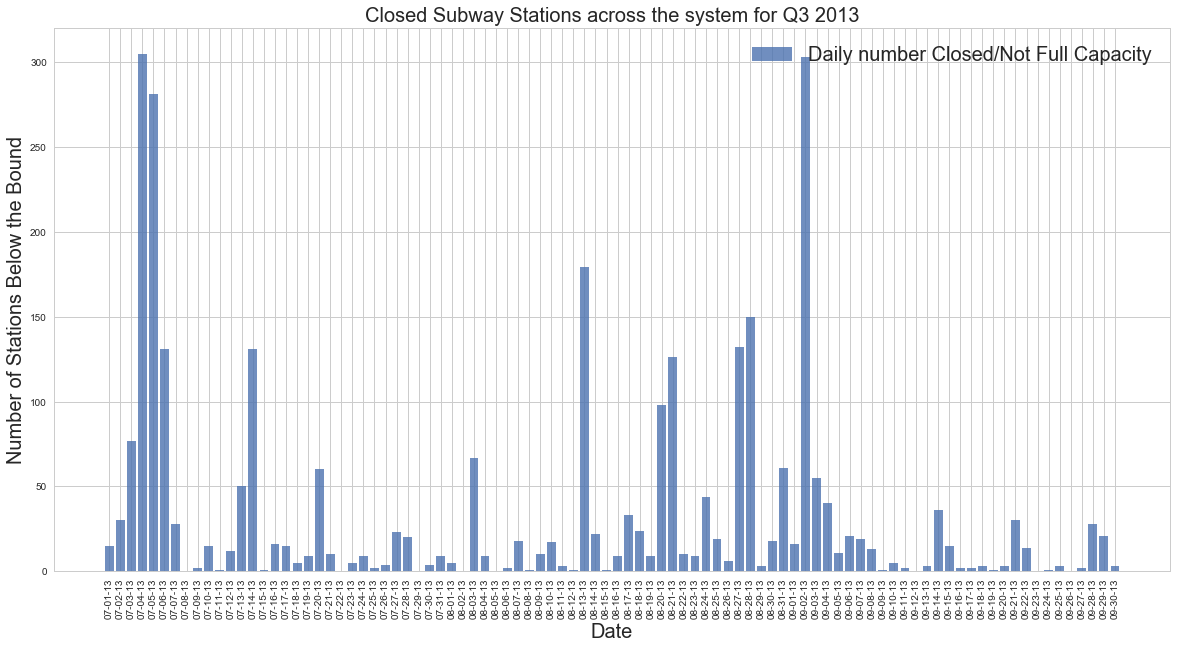

In [549]:
plt.figure(figsize=(20,10))
y_pos = np.arange(len(df))
yvalue = df['Closed Station']
xticket = df.date
plt.bar(y_pos, yvalue,align='center', alpha=0.8,label = 'Daily number Closed/Not Full Capacity')
plt.xticks(y_pos, xticket,fontsize = 10,rotation=90)
plt.legend(prop={'size':20})
plt.xlabel("Date",size=20)
plt.ylabel("Number of Stations Below the Bound",size=20)
plt.title("Closed Subway Stations across the system for Q3 2013",size = 20)
plt.show()

#### Scalar = 2
When the lower bound is 1 std below mean, still a lot of stations are identified as not full capacity, but fewer than the case of scalar = 1.

In [550]:
# Check Q3, bound is 2 std below mean
start = date(2013, 7, 1)
end = date(2013, 9, 30)
dateList = createDateList(start, end)
closed = checkClosed(dateList, 2)

# Scalar = 2
days = pd.Series(key for key in closed.keys())
closedStation = pd.Series(value for value in closed.values())
df = pd.DataFrame(days, columns=['date'])
df['Closed Station'] = closedStation
df.head()

,date,Closed Station
0,07-01-13,2
1,07-02-13,0
2,07-03-13,4
3,07-04-13,285
4,07-05-13,164


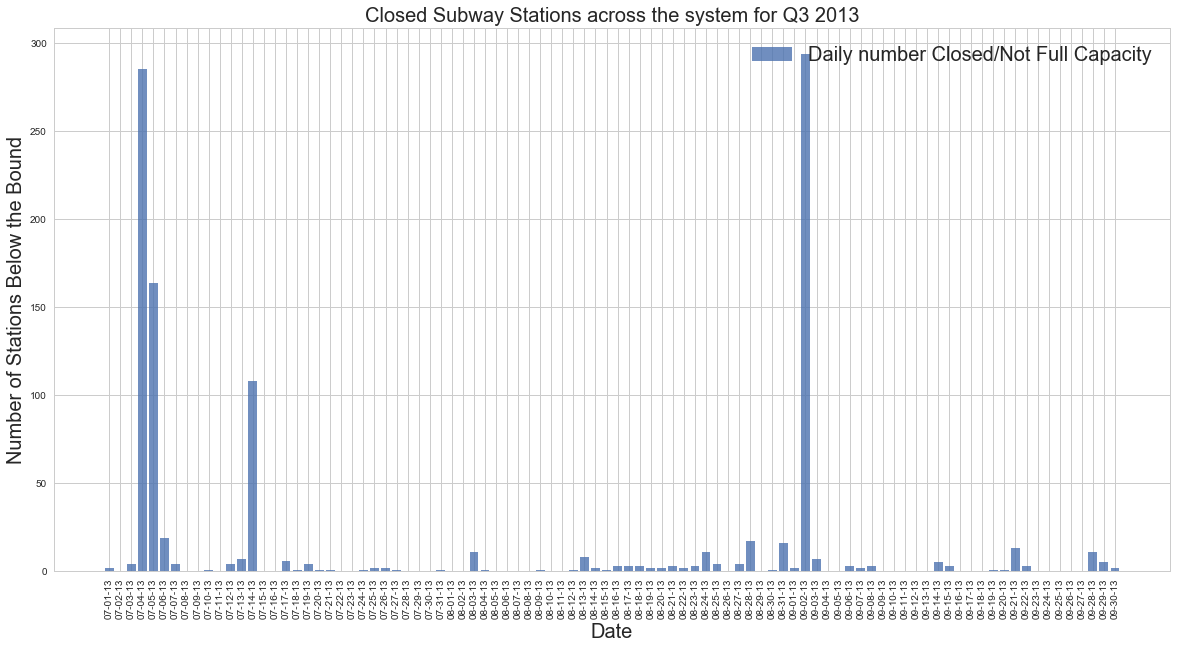

In [551]:
plt.figure(figsize=(20,10))
y_pos = np.arange(len(df))
yvalue = df['Closed Station']
xticket = df.date
plt.bar(y_pos, yvalue,align='center', alpha=0.8,label = 'Daily number Closed/Not Full Capacity')
plt.xticks(y_pos, xticket,fontsize = 10,rotation=90)
plt.legend(prop={'size':20})
plt.xlabel("Date",size=20)
plt.ylabel("Number of Stations Below the Bound",size=20)
plt.title("Closed Subway Stations across the system for Q3 2013",size = 20)
plt.show()

On July 4th, 5th and Sept 2nd, huge number of stations have usual low counts, maybe there's some special events. Now, we want to take a closer look at the other dates. 

### Zoom in and take a Close Look

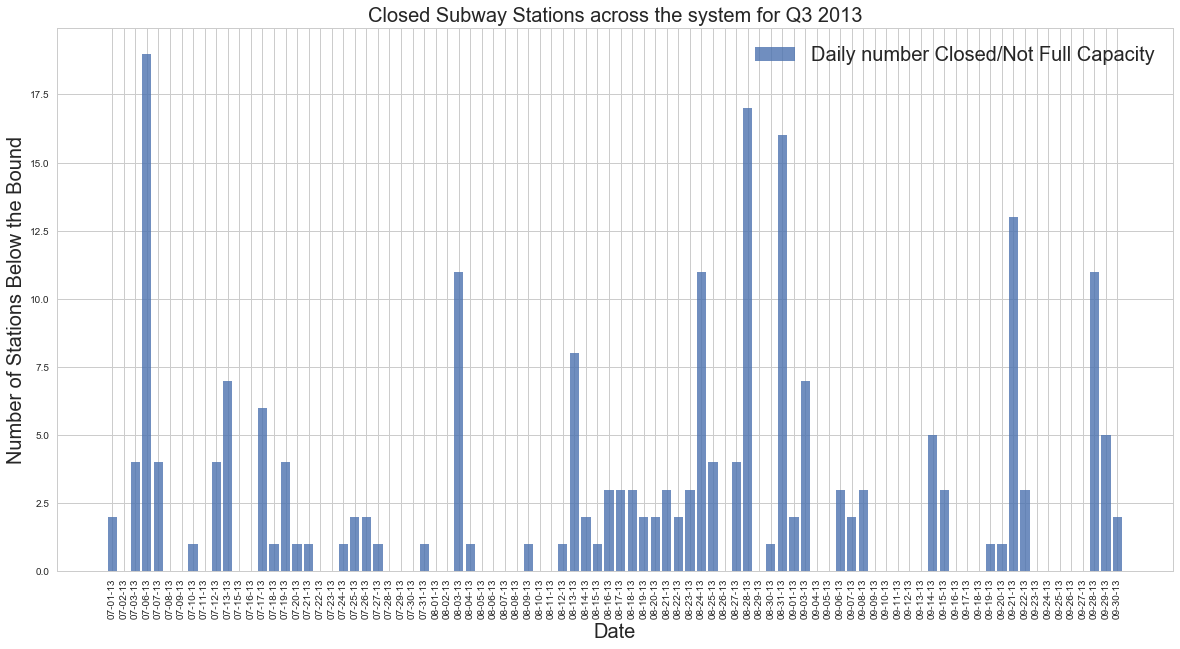

In [553]:
# discard date with huge number
dfOmitOutlier = df[df['Closed Station']<100]

plt.figure(figsize=(20,10))
y_pos = np.arange(len(dfOmitOutlier))
yvalue = dfOmitOutlier['Closed Station']
xticket = dfOmitOutlier.date
plt.bar(y_pos, yvalue,align='center', alpha=0.8,label = 'Daily number Closed/Not Full Capacity')
plt.xticks(y_pos, xticket,fontsize = 10,rotation=90)
plt.legend(prop={'size':20})
plt.xlabel("Date",size=20)
plt.ylabel("Number of Stations Below the Bound",size=20)
plt.title("Closed Subway Stations across the system for Q3 2013",size = 20)
plt.show()

Here's plot showing that how many stations are closed or operating not full capacity in each date of 2013.